# Analysis of current trends in CO2 emissions, concentration levels and deforestation in relation to rising temperatures.

Science almost unanimously says that the main cause of global warming is human emissions of greenhouse gasses and our influence on environment, for example deforestation. This process maginifes the greenhouse effect, natural process allowing life on earth through blocking heat energy from leaving the atmosphere. With this accelaration, more and more energy stays in the atmosphere, warming the planet. 

Aim of this analysis is to investigate the relations between greenhouse gas emissions, deforestation and change in temperatures around the world.

In [1]:
# basic libraries
import pandas as pd
import numpy as np
import re
import random
from random import randrange
import time
# plotting
import matplotlib.pyplot as plt
from matplotlib.ticker import FormatStrFormatter
import matplotlib.colors as plt_c

import matplotlib.image as mpimg
import seaborn as sns
import shapefile
import geopandas as gpd

# bokeh for interactive plots
from bokeh.models import *
from bokeh.plotting import *
from bokeh.io import *
from bokeh.tile_providers import *
from bokeh.palettes import *
from bokeh.transform import *
from bokeh.layouts import *

# Timeseries prediction
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.arima_model import ARIMA
from sklearn.metrics import mean_squared_error
from math import sqrt
from sklearn.model_selection import TimeSeriesSplit
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn import metrics

# Regression
import sklearn.linear_model as linears
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestRegressor
from xgboost.sklearn import XGBRegressor

# stats
import scipy.stats as stats

# additional functions
from add_functions import *

# warnings
import warnings
warnings.filterwarnings("ignore")

#### Reading and preparing data

In [2]:
# reading data

data = pd.read_csv(r"GlobalLandTemperaturesByCity.csv").dropna()
concentration = pd.read_csv(r"Greenhouse_Cooncentration.csv")
good_life = pd.read_csv(r"Good_Life.csv")
greenhouse_gasses = pd.read_csv(r"C:\Users\szklarnia\Desktop\datascience\projekty\globcio\co2-data-master\owid-co2-data.csv") # milion tonnes
co2_emissions = pd.read_csv(r"emissions.csv") # thousand tonnes
forestation = pd.read_csv("FAOSTAT_data_1-27-2021.csv") # thousand tonnes
forest_cover = pd.read_csv("API_AG.LND.FRST.ZS_DS2_en_csv_v2_1926709.csv",skiprows=4)

data.head()

dt  AverageTemperature  AverageTemperatureUncertainty   City  \
0  1743-11-01               6.068                          1.737  Århus   
5  1744-04-01               5.788                          3.624  Århus   
6  1744-05-01              10.644                          1.283  Århus   
7  1744-06-01              14.051                          1.347  Århus   
8  1744-07-01              16.082                          1.396  Århus   

   Country Latitude Longitude  
0  Denmark   57.05N    10.33E  
5  Denmark   57.05N    10.33E  
6  Denmark   57.05N    10.33E  
7  Denmark   57.05N    10.33E  
8  Denmark   57.05N    10.33E

In [3]:
# unit alignments in emission based tables - thousand tonnes
columns = ["co2","cement_co2","coal_co2","flaring_co2","gas_co2","oil_co2","methane","nitrous_oxide"]
greenhouse_gasses[columns] = greenhouse_gasses[columns] * 1000


In [4]:
greenhouse_gasses

iso_code      country  year      co2  co2_growth_prct  co2_growth_abs  \
0          AFG  Afghanistan  1949     15.0              NaN             NaN   
1          AFG  Afghanistan  1950     84.0          475.000           0.070   
2          AFG  Afghanistan  1951     92.0            8.696           0.007   
3          AFG  Afghanistan  1952     92.0            0.000           0.000   
4          AFG  Afghanistan  1953    106.0           16.000           0.015   
...        ...          ...   ...      ...              ...             ...   
24011      ZWE     Zimbabwe  2014  11962.0            2.838           0.330   
24012      ZWE     Zimbabwe  2015  12163.0            1.685           0.202   
24013      ZWE     Zimbabwe  2016  10807.0          -11.146          -1.356   
24014      ZWE     Zimbabwe  2017  12026.0           11.274           1.218   
24015      ZWE     Zimbabwe  2018  12263.0            1.969           0.237   

       consumption_co2  trade_co2  trade_co2_share  co2_per_capita  ...  \
0                  NaN        NaN              NaN           0.002  ...   
1                  NaN        NaN              NaN           0.011  ...   
2                  NaN        NaN              NaN           0.012  ...   
3                  NaN        NaN              NaN           0.012  ...   
4                  NaN        NaN              NaN           0.013  ...   
...                ...        ...              ...             ...  ...   
24011           12.760      0.798            6.671           0.880  ...   
24012           13.010      0.847            6.966           0.880  ...   
24013           11.809      1.001            9.264           0.770  ...   
24014           12.531      0.505            4.198           0.845  ...   
24015              NaN        NaN              NaN           0.849  ...   

       ghg_per_capita  methane  methane_per_capita  nitrous_oxide  \
0                 NaN      NaN                 NaN            NaN   
1                 NaN      NaN                 NaN            NaN   
2                 NaN      NaN                 NaN            NaN   
3                 NaN      NaN                 NaN            NaN   
4                 NaN      NaN                 NaN            NaN   
...               ...      ...                 ...            ...   
24011           4.865  11240.0               0.827         6270.0   
24012           4.885  11870.0               0.859         6680.0   
24013           4.703  11920.0               0.850         6550.0   
24014             NaN      NaN                 NaN            NaN   
24015             NaN      NaN                 NaN            NaN   

       nitrous_oxide_per_capita  primary_energy_consumption  \
0                           NaN                         NaN   
1                           NaN                         NaN   
2                           NaN                         NaN   
3                           NaN                         NaN   
4                           NaN                         NaN   
...                         ...                         ...   
24011                     0.461                         NaN   
24012                     0.484                         NaN   
24013                     0.467                         NaN   
24014                       NaN                         NaN   
24015                       NaN                         NaN   

       energy_per_capita  energy_per_gdp  population           gdp  
0                    NaN             NaN   7663783.0           NaN  
1                    NaN             NaN   7752000.0  1.949480e+10  
2                    NaN             NaN   7840000.0  2.006385e+10  
3                    NaN             NaN   7936000.0  2.074235e+10  
4                    NaN             NaN   8040000.0  2.201546e+10  
...                  ...             ...         ...           ...  
24011                NaN             NaN  13587000.0  2.474828e+10  
24012             

In [5]:
# creating "year" column for easier yearly mean calculation
# for date in data.dt:
data["year"] = [int(date[0:4]) for date in data.dt]
data.year

0          1743
5          1744
6          1744
7          1744
8          1744
           ... 
8599206    2013
8599207    2013
8599208    2013
8599209    2013
8599210    2013
Name: year, Length: 8235082, dtype: int64

### Analysis and visualization

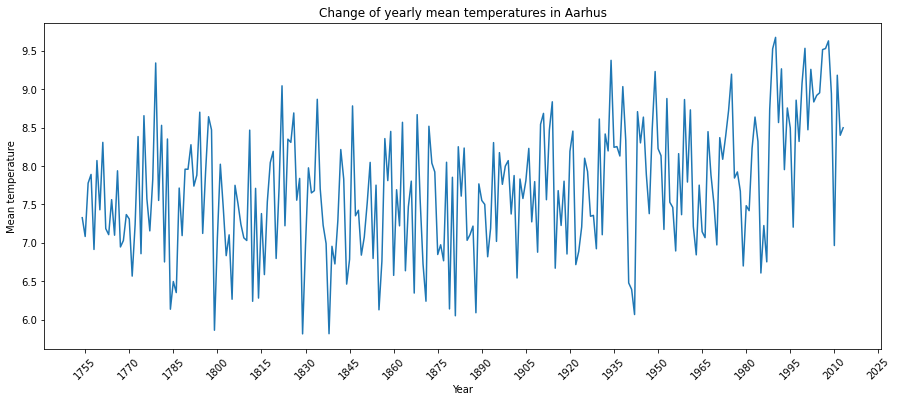

In [6]:
# Plotting yearly temperatures for Aarhus - first look at the data

aarhus = data[data.City == "Århus"]
aarhus = aarhus[50:]
yearly = aarhus.groupby("year").mean()

plt.figure(figsize=(15,6))
plt.plot(yearly.index, yearly.AverageTemperature)
plt.xlabel("Year")
plt.ylabel("Mean temperature")
# limiting number of xticks 
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.title("Change of yearly mean temperatures in Aarhus")
plt.show()

Plot for Aarhus shows that yearly mean temperatures have slightly risen. Test will show if this trend is present around the world

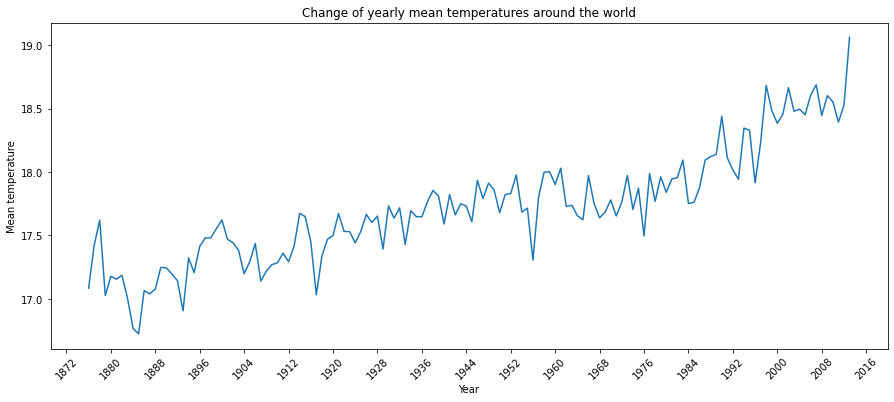

In [7]:
# plotting mean temperature around the world

# grouping data
yearly_world = data.groupby("year").mean()
yearly_world = yearly_world[yearly_world.index > 1875]

# plotting
plt.figure(figsize=(15,6))
plt.plot(yearly_world.index, yearly_world.AverageTemperature)
plt.xlabel("Year")
plt.ylabel("Mean temperature")
# limiting number of xticks 
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
plt.xticks(rotation=45)
plt.title("Change of yearly mean temperatures around the world")
plt.show()

Plot shows steady rise of mean temperatures around the world. Are the change statistically significant

### Is the temperature in 2000s significantly higher than in 1900s?

In [8]:

# grouping data by city
data_grouped = data.groupby(["City","year"]).mean().reset_index()


In [9]:
# checking if mean temperatures in cities in datasets have changed using temperature_mean_change function
hotter, unchanged = temperature_mean_change(data_grouped)

In [10]:
# changing hotter into series for easier calculations
hotter_series = pd.Series(hotter)

In [11]:
# printinh out results
print(f"Out of {len(data_grouped.City.unique())} cities in dataset, in {len(hotter)} of them mean temperature between years 2000 and 2013 is significantly higher than between 1900 and 1990.")
print(f"This makes {len(data_grouped.City.unique())/len(hotter)*100} percent of the dataset")
print(f"City with highest mean temperature change is {hotter_series.idxmax()} in {data[data.City==hotter_series.idxmax()].Country.iloc[0]} with change of {hotter_series.max()}")
print(f"City with lowest mean temperature change is {hotter_series.idxmin()} in {data[data.City==hotter_series.idxmin()].Country.iloc[0]} with change of {hotter_series.min()}")

Out of 3448 cities in dataset, in 3448 of them mean temperature between years 2000 and 2013 is significantly higher than between 1900 and 1990.
This makes 100.0 percent of the dataset
City with highest mean temperature change is Engels in Russia with change of 1.901936813186813
City with lowest mean temperature change is Juliaca in Peru with change of 0.2560533424908433


Statistical tests have shown that in all of the cities mean temperatures have significantly risen in relation to mean from XX century. There is no place on earth without temperature rise. In the worst case temperature has almost crossed the 2 celcius rise threshold already, as for 2012.

### Visualizing mean temperature rise by country

In [12]:
# reading vector map
shp_path = r"C:\Users\szklarnia\Desktop\datascience\projekty\globcio\vector\World_Countries.shp"

# creating GeoDataFrame with data and map info
map_df = gpd.read_file(shp_path).rename({"COUNTRY":"Country"},axis=1)


In [13]:
# preparing data to merge with geodatafame
data_by_country = data.groupby(["Country","year"]).mean().reset_index()
country_means = data_by_country[(data_by_country.year>=1900)&(data_by_country.year<=2000)].groupby("Country").mean()

for i in range(len(data_by_country.Country)):
    data_by_country.AverageTemperature[i] = data_by_country.AverageTemperature[i]-country_means[country_means.index == data_by_country.Country[i]].AverageTemperature

In [14]:
# merging data and saving them in geodataframe format
temp_by_countries = map_df.merge(data_by_country,on="Country")
temp_by_countries = gpd.GeoDataFrame(temp_by_countries)

In [15]:
# These two tiny islands will serve as the maximum and minimum values to keep the scale identical among plots
geometry_aruba = map_df[map_df.Country=="Aruba (Netherlands)"].geometry.values[0]
geometry_timor = map_df[map_df.Country=="East Timor"].geometry.values[0]

for i in range(len(temp_by_countries.year.unique())):
    value1 = {"Country":"Aruba","geometry":geometry_aruba,"year":temp_by_countries.year.unique()[i],"AverageTemperature":2}
    value2 = {"Country":"Timor","geometry":geometry_timor,"year":temp_by_countries.year.unique()[i],"AverageTemperature":-2}
    temp_by_countries = temp_by_countries.append(value1,ignore_index=True)
    temp_by_countries = temp_by_countries.append(value2,ignore_index=True)


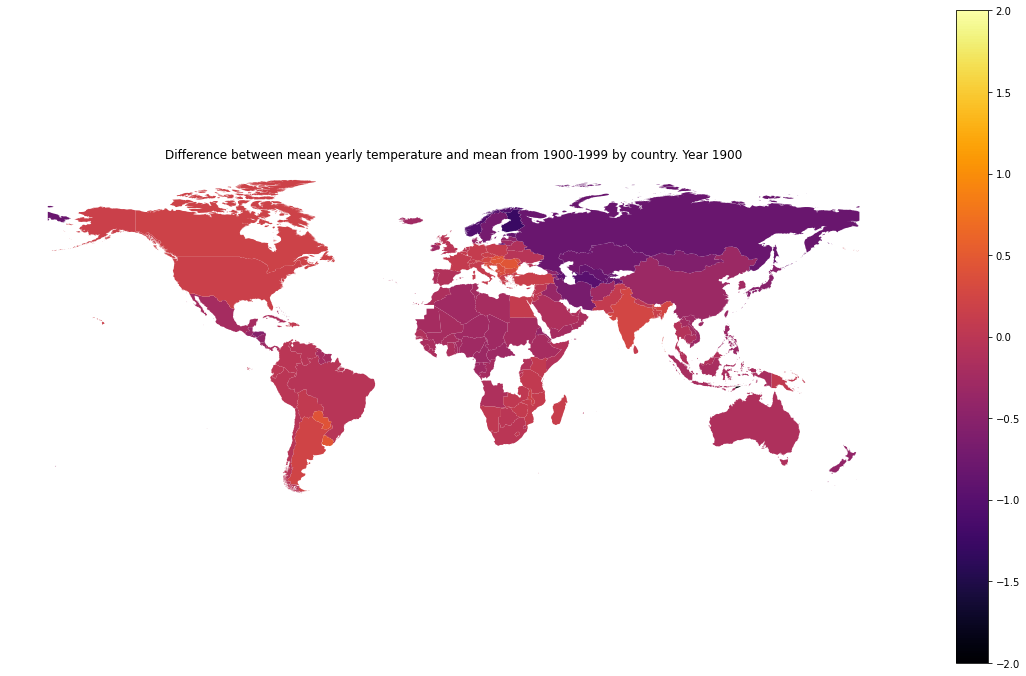

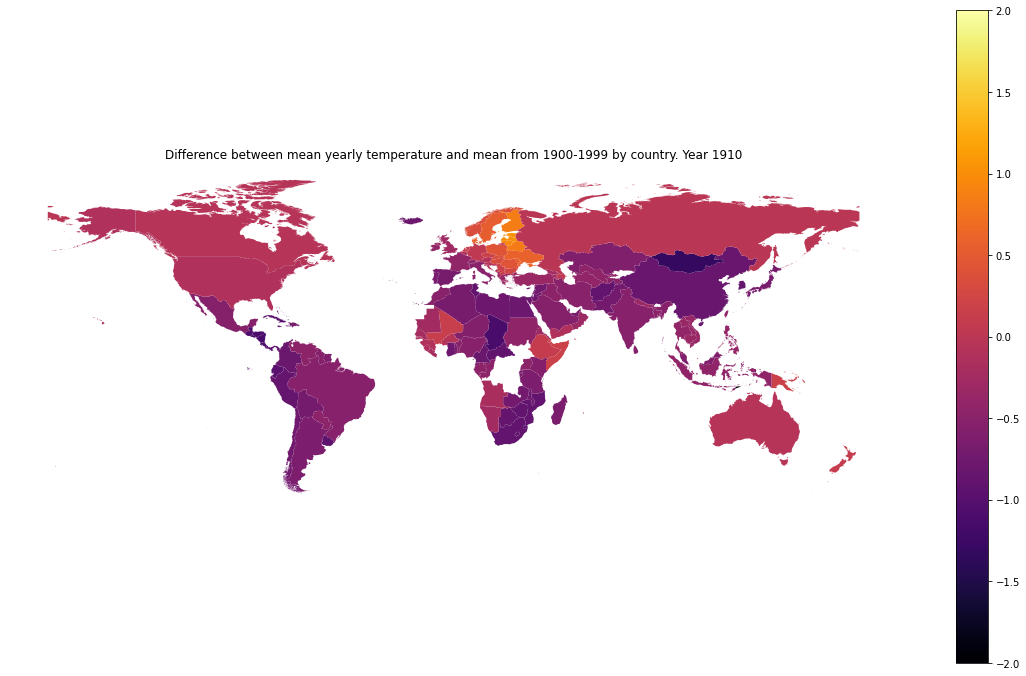

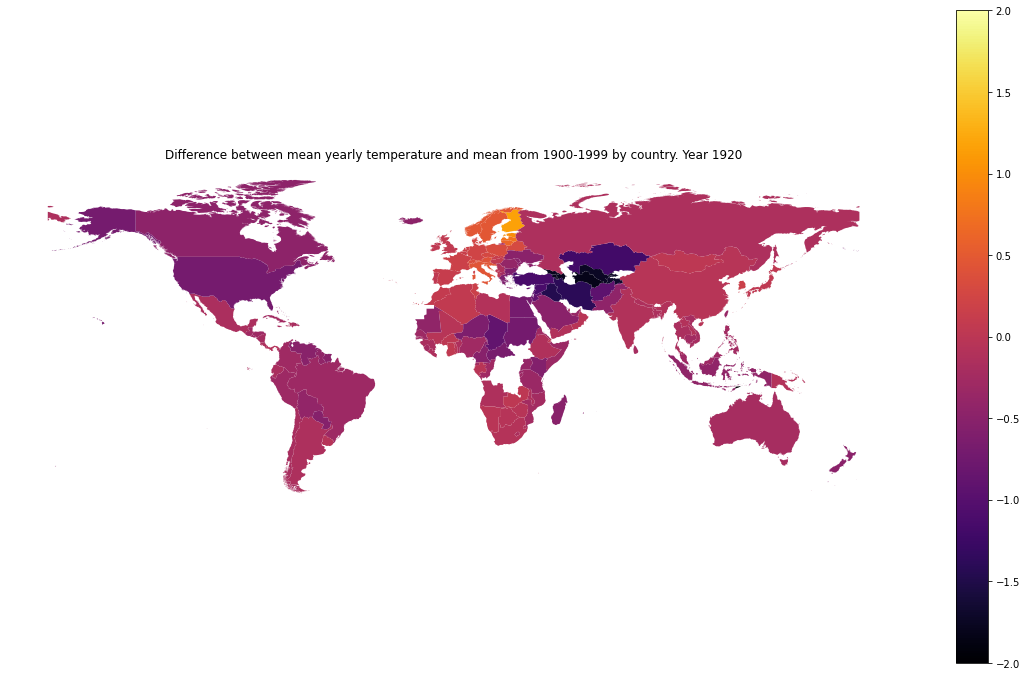

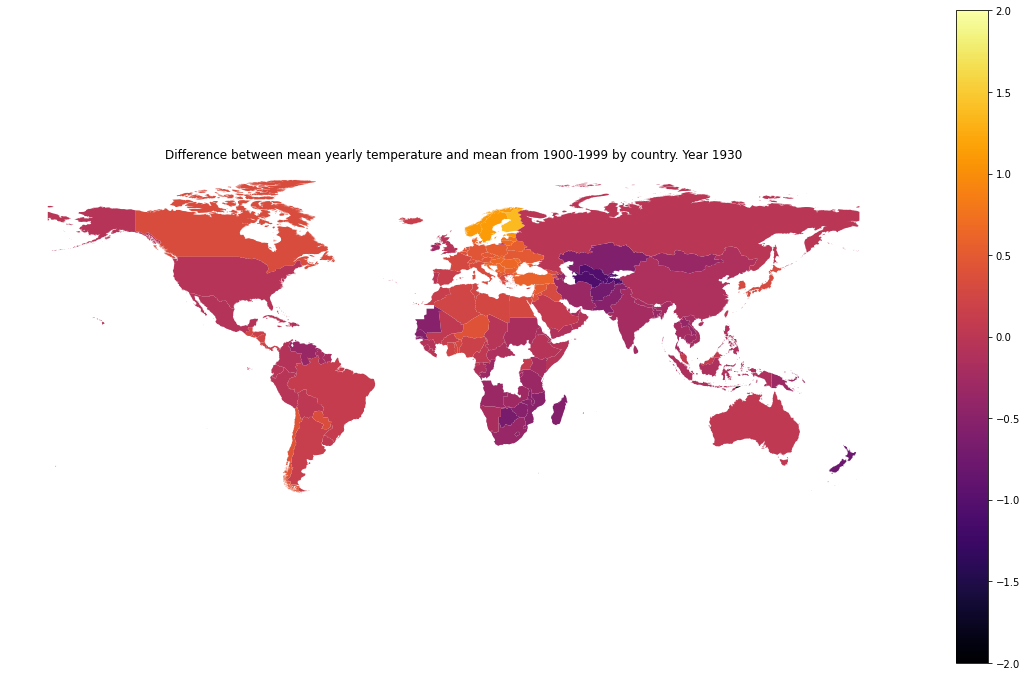

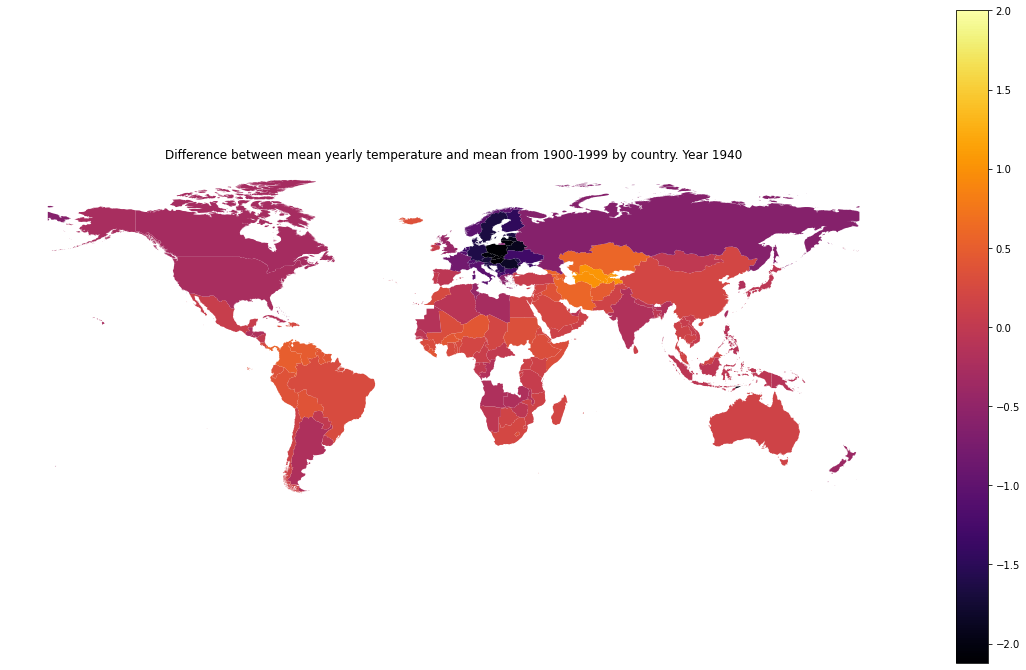

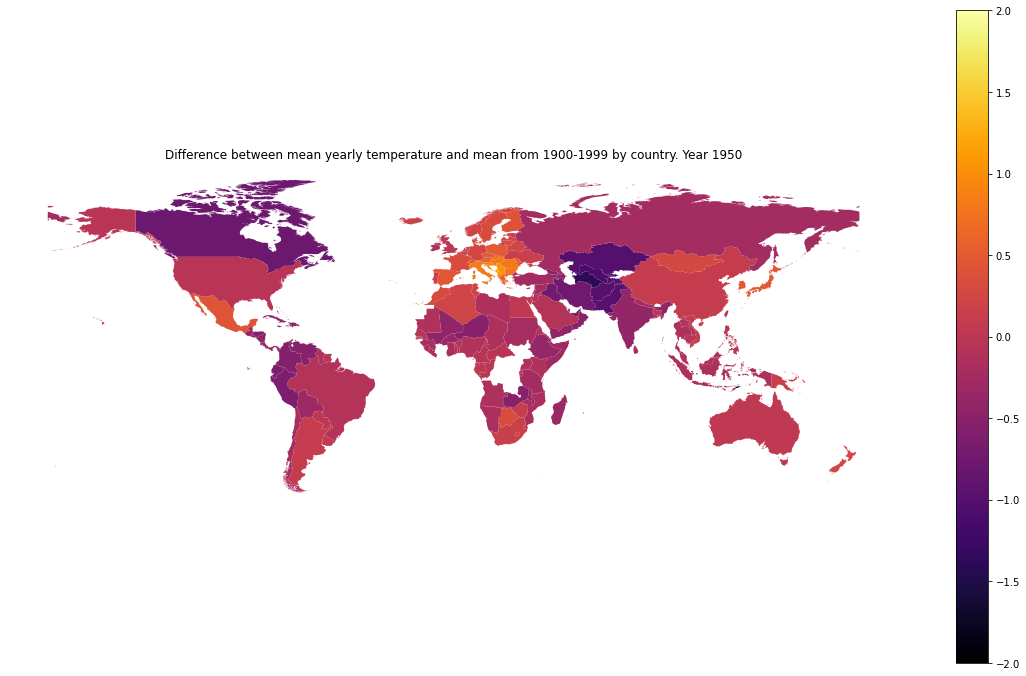

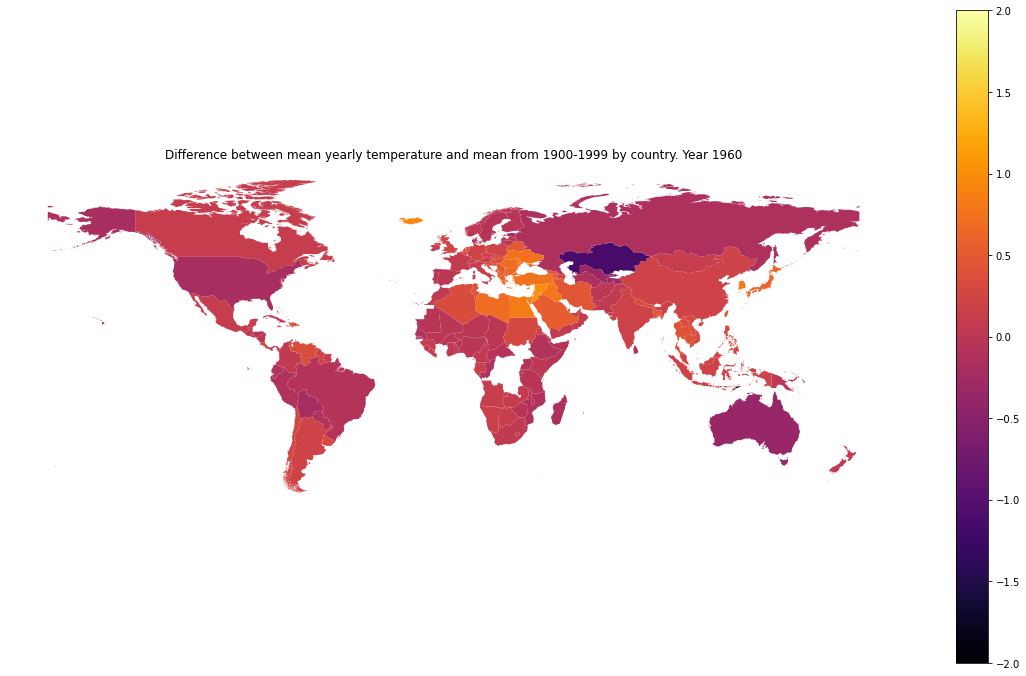

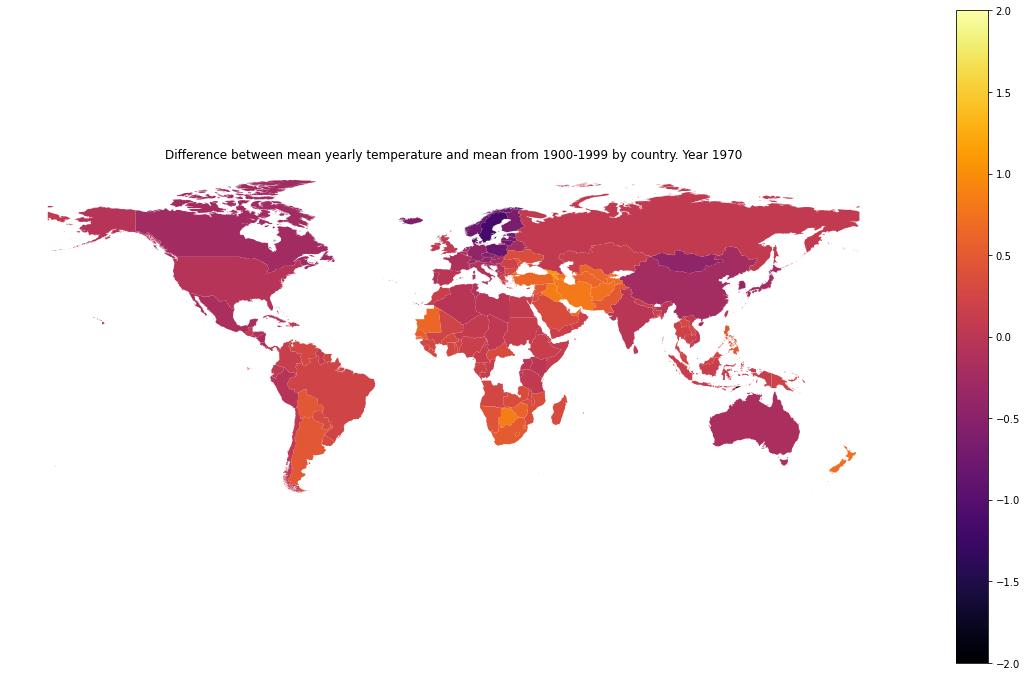

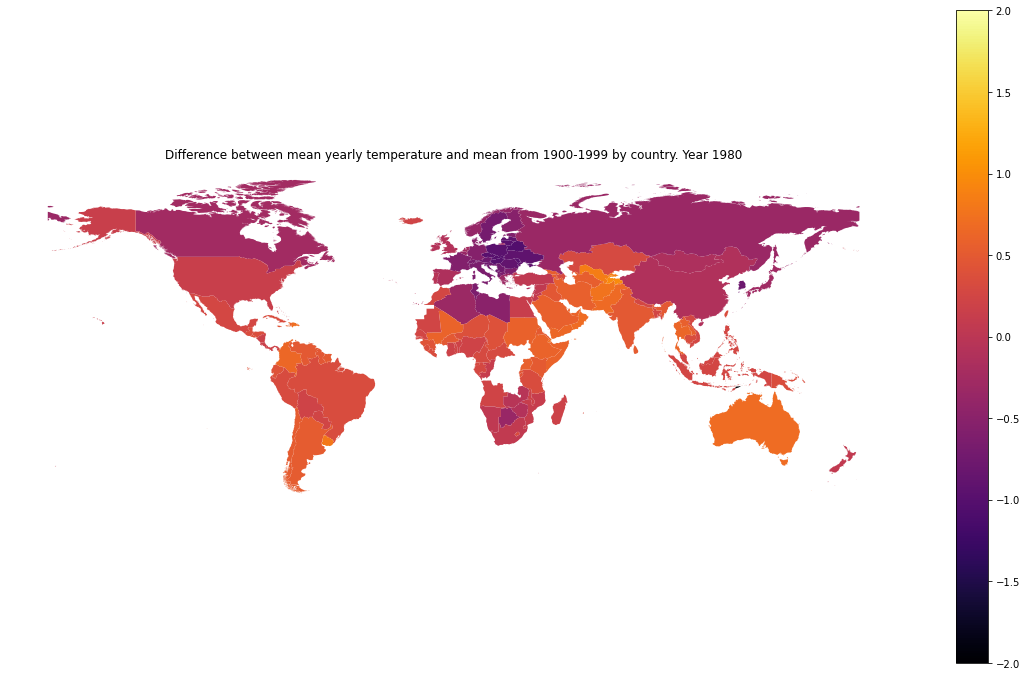

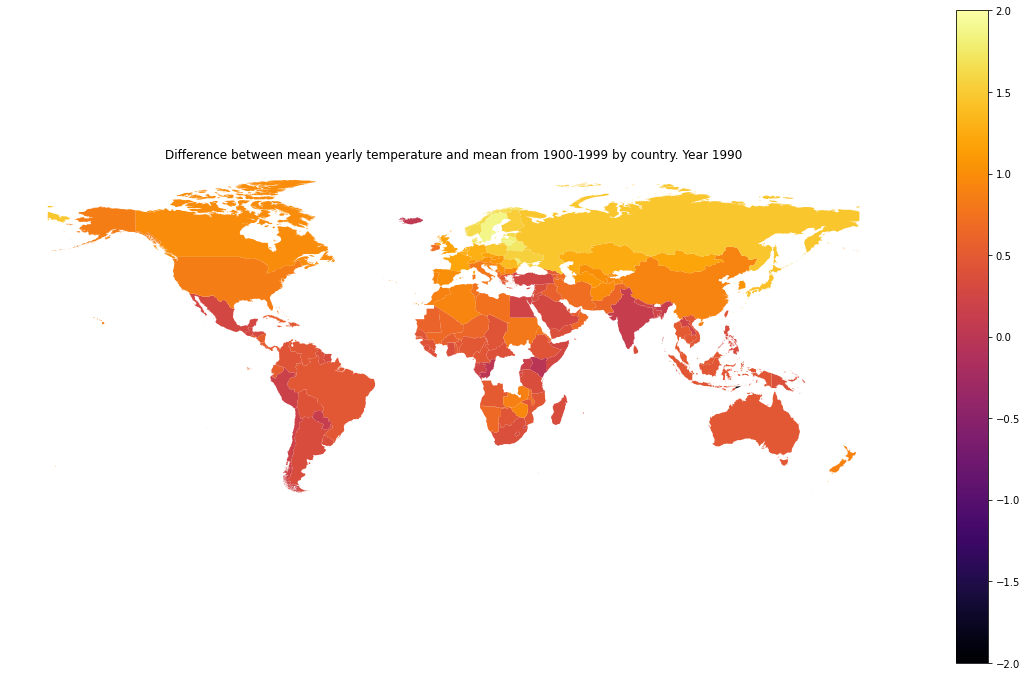

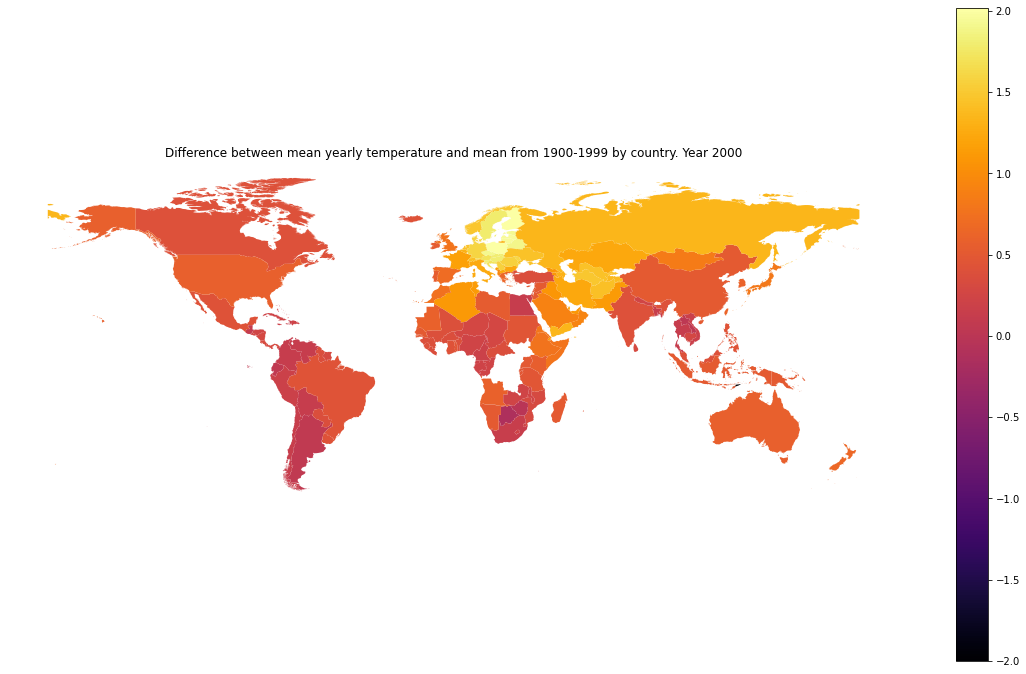

In [16]:
# plotting differences between yearly mean temperature and mean temperature fo XX century
for i in np.arange(1900,2010,10):

    to_plot = temp_by_countries[temp_by_countries.year == i]

    fig, ax = plt.subplots(1,figsize=(20,12))
    to_plot.plot(column="AverageTemperature",ax=ax,cmap="inferno",legend=True)
    plt.title(f"Difference between mean yearly temperature and mean from 1900-1999 by country. Year {i}")
    ax.axis("off")


Over the years, dominant color palette for the map became much yellower, signifying a rise in temperatures

### Visualising mean temperature rise by city

In [17]:
# grouping data by cities
cities_grouped = data.groupby(["City","year"]).mean().reset_index()
cities_grouped = cities_grouped.merge(data[["City","Latitude","Longitude"]].drop_duplicates(),on="City")
cities_grouped = cities_grouped[cities_grouped.year > 1850]

In [18]:
# computing mean values of temperature during XX century for each city
cities_means = cities_grouped[(cities_grouped.year>=1900)&(cities_grouped.year<=2000)].groupby("City").mean().reset_index()

for i in range(len(cities_grouped.City)):
    cities_grouped.AverageTemperature.iloc[i] = cities_grouped.AverageTemperature.iloc[i]-cities_means[cities_means.City == cities_grouped.City.iloc[i]].AverageTemperature

In [19]:
cities_grouped.dropna(inplace=True)

In [20]:
cities_grouped = cities_grouped.reset_index().drop("index",axis=1)

In [21]:
cities_grouped

City  year  AverageTemperature  AverageTemperatureUncertainty  \
0       A Coruña  1851           -0.337087                       1.996667   
1       A Coruña  1852            0.269163                       1.510417   
2       A Coruña  1853           -1.481253                       1.594333   
3       A Coruña  1854           -0.287920                       1.589750   
4       A Coruña  1855           -1.100920                       1.602250   
...          ...   ...                 ...                            ...   
561117    Ürümqi  2009            1.198748                       0.520333   
561118    Ürümqi  2010            0.561414                       1.028417   
561119    Ürümqi  2011            0.717414                       0.702750   
561120    Ürümqi  2012            0.511498                       0.842667   
561121    Ürümqi  2013            3.383331                       0.841000   

       Latitude Longitude  
0        42.59N     8.73W  
1        42.59N     8.73W  
2        42.59N     8.73W  
3        42.59N     8.73W  
4        42.59N     8.73W  
...         ...       ...  
561117   44.20N    87.20E  
561118   44.20N    87.20E  
561119   44.20N    87.20E  
561120   44.20N    87.20E  
561121   44.20N    87.20E  

[561122 rows x 6 columns]

In [22]:
# translating coordinates
Lat,Long = translate_coordinates(cities_grouped,lat_col="Latitude",lon_col="Longitude")

In [23]:
cities_grouped.Latitude = Lat
cities_grouped.Longitude = Long

In [24]:
cities_grouped

City  year  AverageTemperature  AverageTemperatureUncertainty  \
0       A Coruña  1851           -0.337087                       1.996667   
1       A Coruña  1852            0.269163                       1.510417   
2       A Coruña  1853           -1.481253                       1.594333   
3       A Coruña  1854           -0.287920                       1.589750   
4       A Coruña  1855           -1.100920                       1.602250   
...          ...   ...                 ...                            ...   
561117    Ürümqi  2009            1.198748                       0.520333   
561118    Ürümqi  2010            0.561414                       1.028417   
561119    Ürümqi  2011            0.717414                       0.702750   
561120    Ürümqi  2012            0.511498                       0.842667   
561121    Ürümqi  2013            3.383331                       0.841000   

        Latitude  Longitude  
0          42.59      -8.73  
1          42.59      -8.73  
2          42.59      -8.73  
3          42.59      -8.73  
4          42.59      -8.73  
...          ...        ...  
561117     44.20      87.20  
561118     44.20      87.20  
561119     44.20      87.20  
561120     44.20      87.20  
561121     44.20      87.20  

[561122 rows x 6 columns]

In [25]:
# creating geo_data_frame
gdf = geodf_create_transform(cities_grouped, "Longitude", "Latitude", to_resize=None, resize=5)

In [26]:
# specyfying maximum and minimum range of plot
x_range, y_range = get_max_min(179, -179, 85, -85)

In [27]:
gdf

City  year  AverageTemperature  AverageTemperatureUncertainty  \
0       A Coruña  1851           -0.337087                       1.996667   
1       A Coruña  1852            0.269163                       1.510417   
2       A Coruña  1853           -1.481253                       1.594333   
3       A Coruña  1854           -0.287920                       1.589750   
4       A Coruña  1855           -1.100920                       1.602250   
...          ...   ...                 ...                            ...   
561117    Ürümqi  2009            1.198748                       0.520333   
561118    Ürümqi  2010            0.561414                       1.028417   
561119    Ürümqi  2011            0.717414                       0.702750   
561120    Ürümqi  2012            0.511498                       0.842667   
561121    Ürümqi  2013            3.383331                       0.841000   

        Latitude  Longitude                         geometry        x_crds  \
0          42.59      -8.73  POINT (-971819.155 5249772.433) -9.718192e+05   
1          42.59      -8.73  POINT (-971819.155 5249772.433) -9.718192e+05   
2          42.59      -8.73  POINT (-971819.155 5249772.433) -9.718192e+05   
3          42.59      -8.73  POINT (-971819.155 5249772.433) -9.718192e+05   
4          42.59      -8.73  POINT (-971819.155 5249772.433) -9.718192e+05   
...          ...        ...                              ...           ...   
561117     44.20      87.20  POINT (9707059.597 5496444.990)  9.707060e+06   
561118     44.20      87.20  POINT (9707059.597 5496444.990)  9.707060e+06   
561119     44.20      87.20  POINT (9707059.597 5496444.990)  9.707060e+06   
561120     44.20      87.20  POINT (9707059.597 5496444.990)  9.707060e+06   
561121     44.20      87.20  POINT (9707059.597 5496444.990)  9.707060e+06   

              y_crds  
0       5.249772e+06  
1       5.249772e+06  
2       5.249772e+06  
3       5.249772e+06  
4       5.249772e+06  
...              ...  
561117  5.496445e+06  
561118  5.496445e+06  
561119  5.496445e+06  
561120  5.496445e+06  
561121  5.496445e+06  

[561122 rows x 9 columns]

In [28]:
# specyfying color map
from bokeh.palettes import Turbo
mapper = linear_cmap(field_name='AverageTemperature', palette=Turbo256 ,low=-3 ,high=3)


In [29]:
# creating dynamic plot
years = np.arange(1920,2013,1)

# specyfying source
source = ColumnDataSource(gdf.drop("geometry",axis=1)[gdf.year == 1920])
# creating plot
p = plot_bubble_map(df=gdf,
                source=source,
                radius_col=100000,
                hover_tuples=[("Lat:","@Latitude"),("Long:","@Longitude"),("Name:","@City")],
                x_range=x_range,
                y_range=y_range,
                title = f"Difference between yearly mean temperatures and 1900-1999 average. Year = 1850",
                leg_label = "Mean temperature in city",
                color=mapper)

# creatung color bar
color_bar = ColorBar(color_mapper=mapper['transform'], width=8,  location=(0,0))
p.add_layout(color_bar, 'right')
# creating handle object, output in jupyter notebook
output_notebook()
handle = show(p, notebook_handle = True)

# updating plot yearly
for year in years:
    # specyfying new source dataframe, changing title
    df = gdf[gdf.year == year].drop("geometry",axis=1)
    p.title.text = f"Difference between yearly mean temperatures and 1900-1999 average. Year = {year}"
    # Push new data
    source.stream(df)
    # Purge old data
    source.data = df
    push_notebook(handle=handle)
    time.sleep(.02)

Loading BokehJS ...

## Choosing cities for more detailed analisys

In [30]:
# choosing countries for analisys -- aiming for variety

countries = ["Norway","Ireland","Italy","Mexico","Peru","Ethiopia","Nigeria","South Korea","India","New Zealand","Jordan","Iran","South Africa","Australia"]

In [31]:
data_chosen = data[data.Country.isin(countries)]

In [32]:
# choosing cities for analisys:
cities = []
for country in countries:
    data_country = data_chosen[data_chosen.Country == country]
    city = random.choice(list(data_country.City.unique()))
    cities.append(city)

In [33]:
list(cities)

['Stavanger',
 'Cork',
 'Genoa',
 'Zamora',
 'Ica',
 'Nazret',
 'Minna',
 'Seoul',
 'Adoni',
 'Christchurch',
 'Irbid',
 'Gorgan',
 'Paarl',
 'Cairns']

In [34]:
# creating dataframe with data only for chosen cities
data_cities = data[data.City.isin(cities)].reset_index().drop("index",axis=1)
# replacing longitude and latitude with numerical values
Lat,Long = translate_coordinates(data_cities,"Latitude","Longitude")

In [35]:
data_cities["Latitude"] = Lat
data_cities["Longitude"] = Long

In [36]:
Lat

0        15.27
1        15.27
2        15.27
3        15.27
4        15.27
         ...  
31525    20.09
31526    20.09
31527    20.09
31528    20.09
31529    20.09
Length: 31530, dtype: float64

In [37]:
# creating geodataframe
cities_gdf = geodf_create_transform(data_cities,"Longitude","Latitude")

In [38]:
type(cities_gdf.dt[0])

str

In [39]:
# Bokeh data source 
cities_source = ColumnDataSource(cities_gdf.drop("geometry",axis=1)[cities_gdf.dt=="1990-01-01"])

In [40]:
# Showing geographical locations of chosen cities on a world map

p = plot_bubble_map(df=cities_gdf,
                source=cities_source,
                radius_col=100000,
                hover_tuples=[("Name:","@City"),("Country:","@Country"),("Lat:","@Latitude"),("Long:","@Longitude")],
                x_range=x_range,
                y_range=y_range,
                title = "Chosen cities positioned on a map",
                leg_label = "Cities",
                color="black")

show(p)
output_notebook()

Loading BokehJS ...

In [41]:
# creating dictionary with dataframes for each city for easier access
cities_dict = {}

for city in cities:
    data_city = data_cities[data_cities.City == city]
    
    # dropping data from years where there are gaps in data (less than 12 values)
    by_years = data_city.groupby("year").size()
    years_to_drop = []
    for year in list(by_years.index):
        if by_years[year] != 12:
            years_to_drop.append(year)
    data_city.drop(data_city[data_city.year.isin(years_to_drop)].index,inplace=True)        

    
    
    # adding resulting dataframe to a dictionary
    cities_dict[city] = data_city


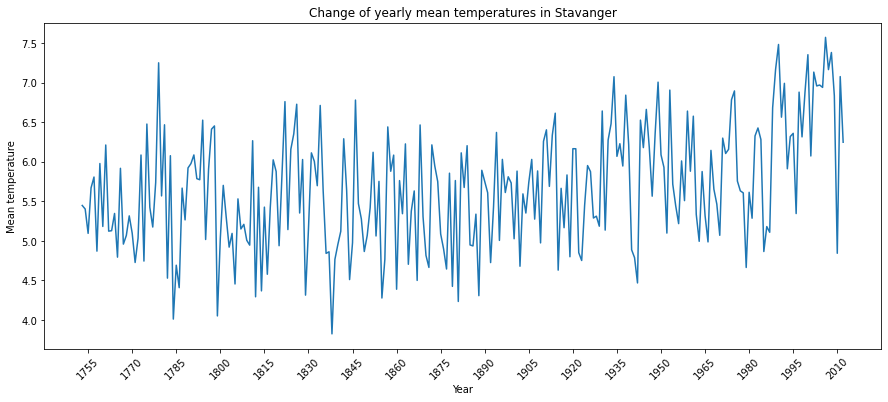

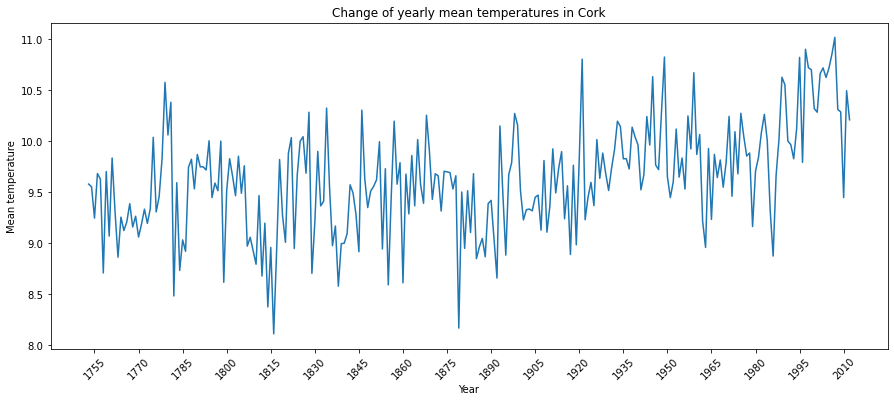

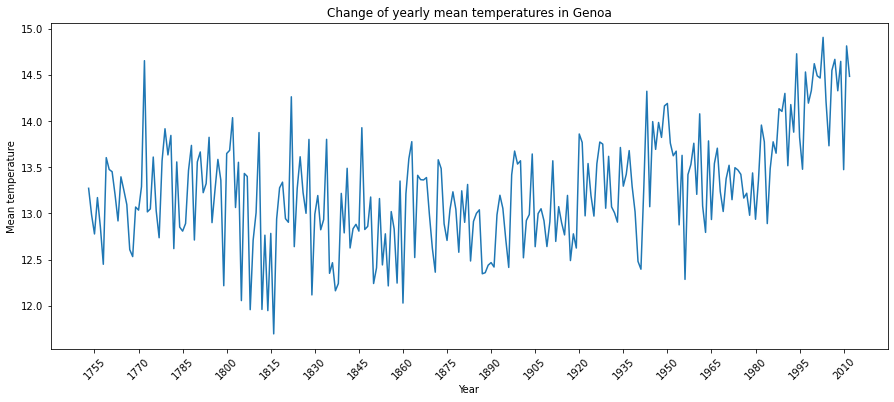

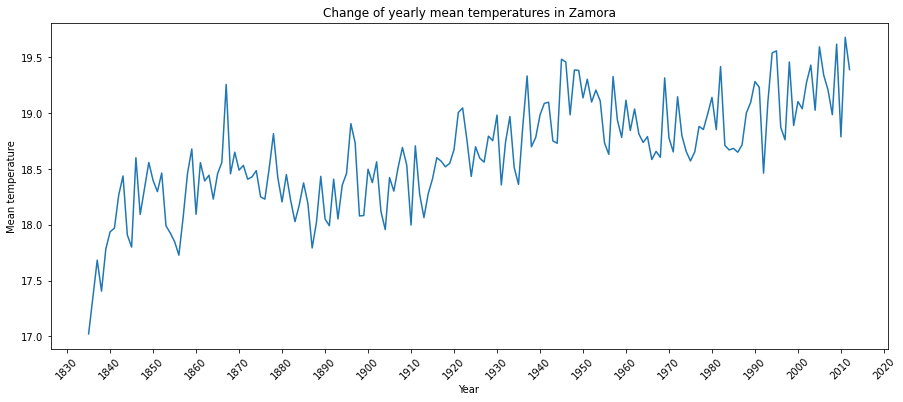

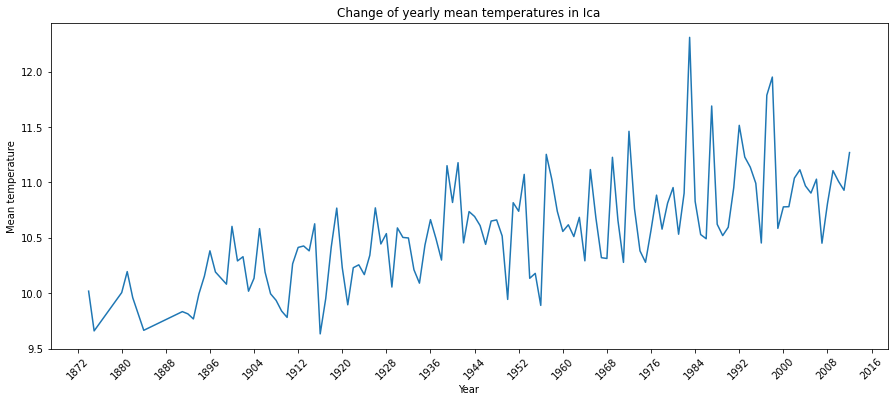

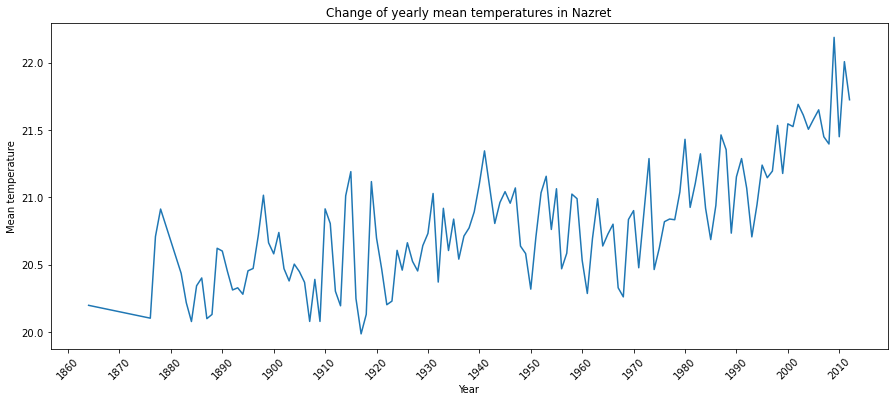

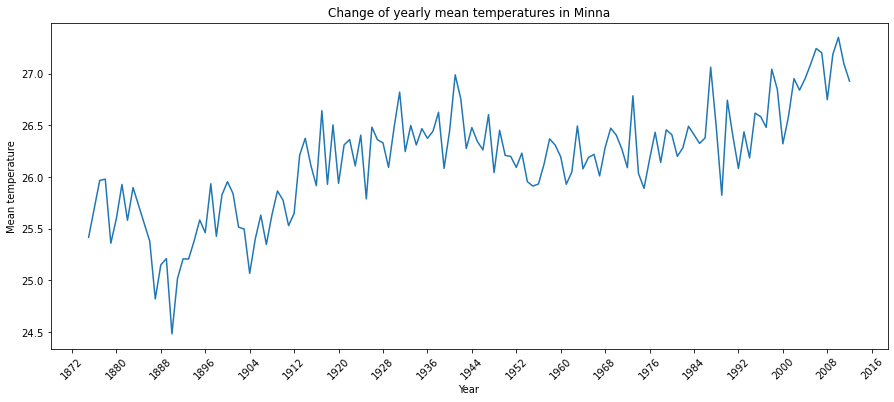

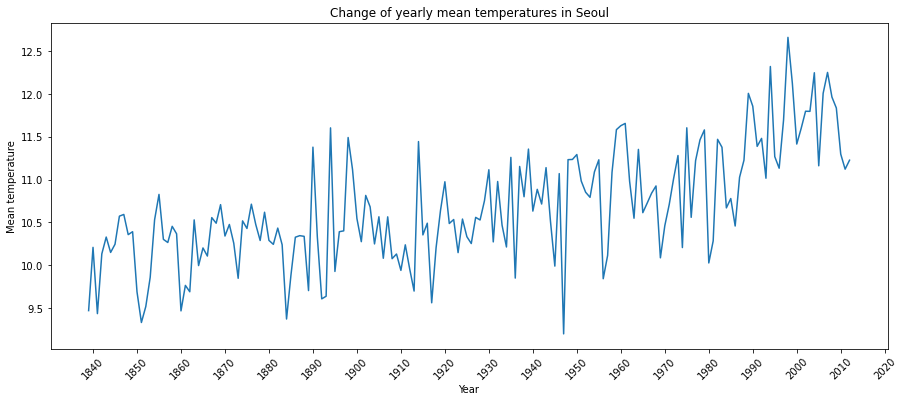

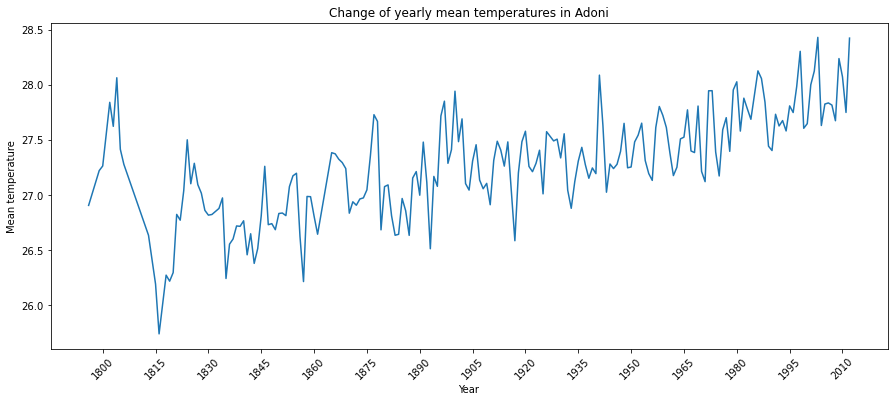

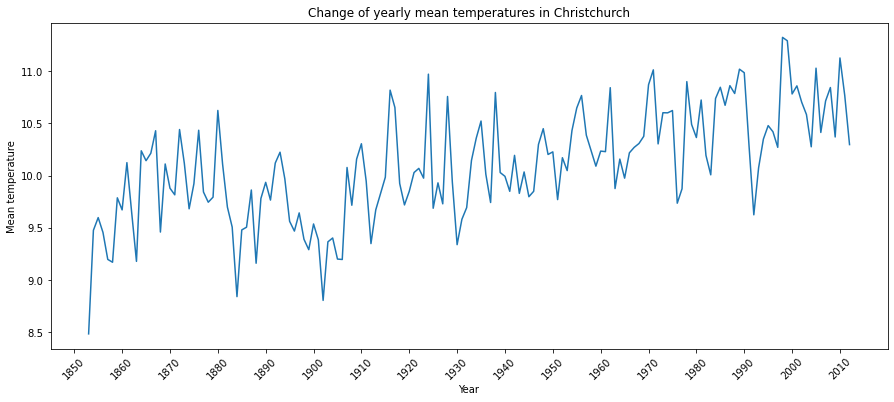

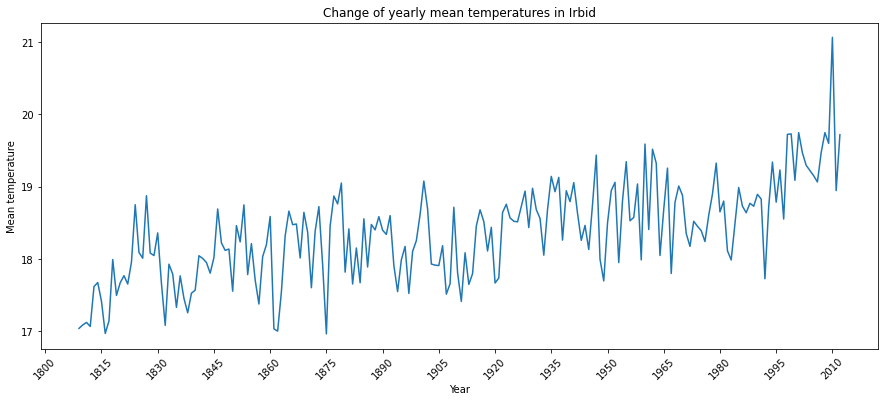

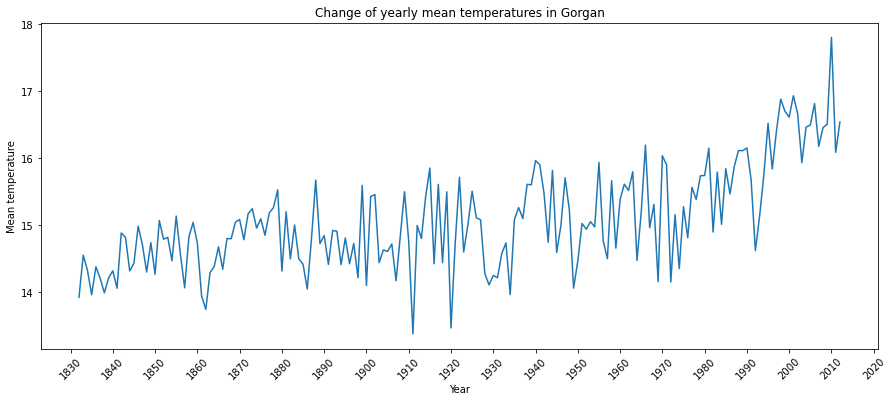

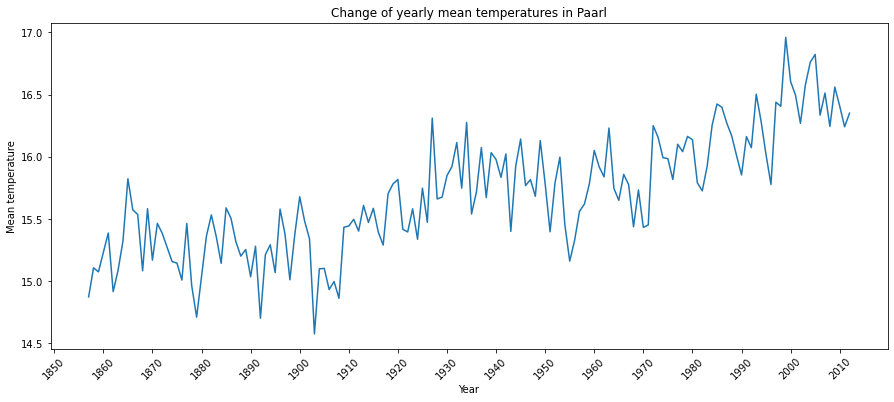

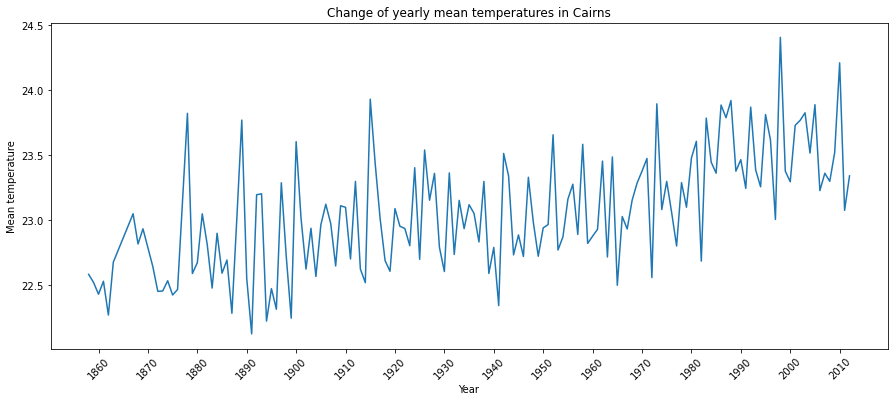

In [42]:
# plotting yearly mean temperatures for chosen cities

# iterating over cities
for key in cities_dict.keys():
    # creating yearly means for each place
    data_city = cities_dict[key]
    yearly = data_city.groupby("year").mean()
    
    # plotting
    plt.figure(figsize=(15,6))
    plt.plot(yearly.index, yearly.AverageTemperature)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of ticks showing on x axis
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.title(f"Change of yearly mean temperatures in {key}")

plt.show()

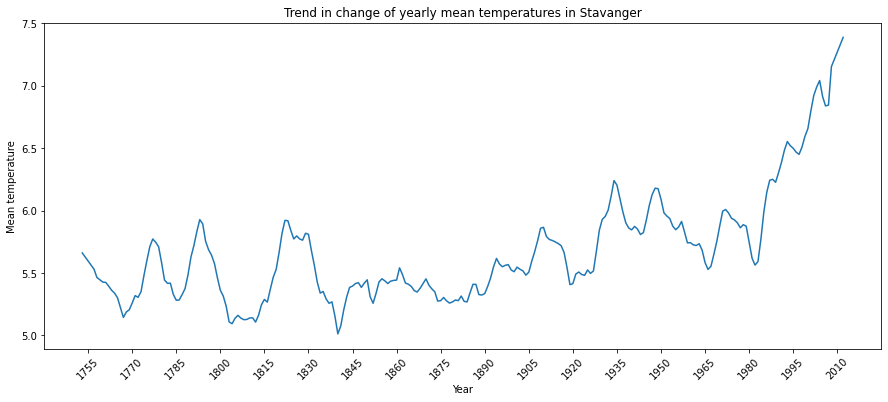

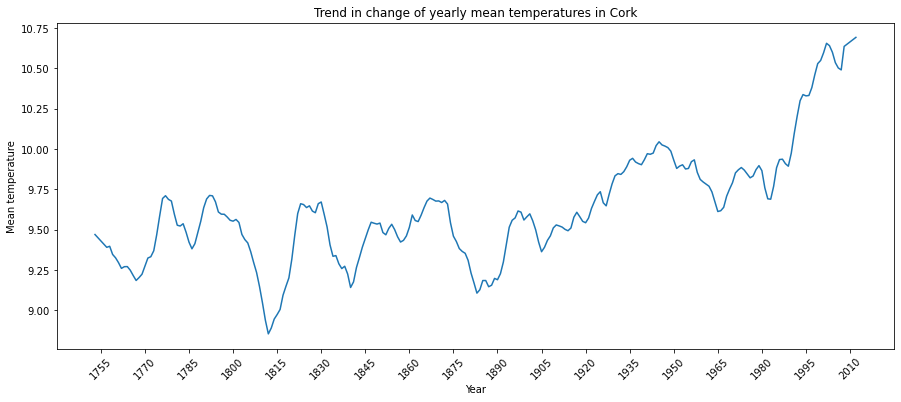

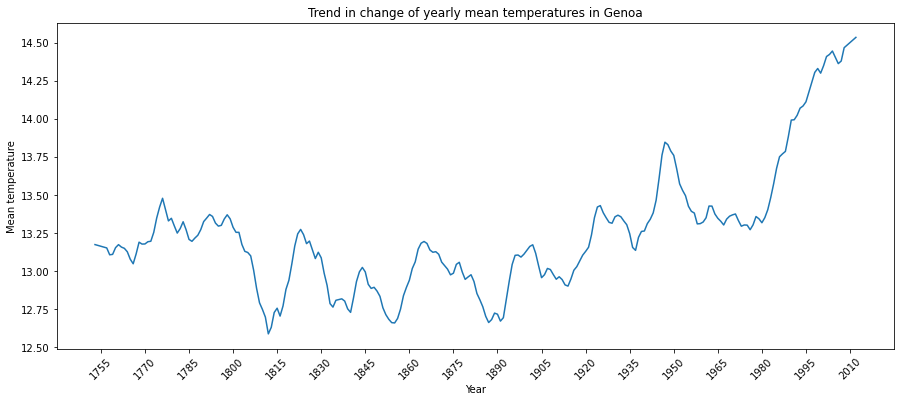

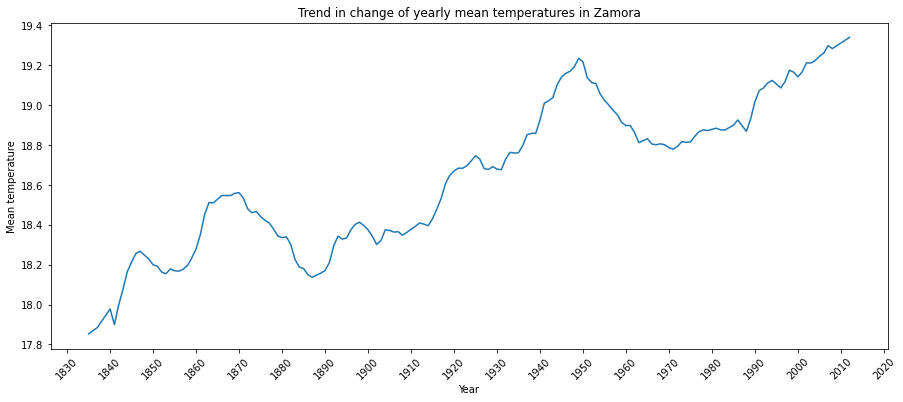

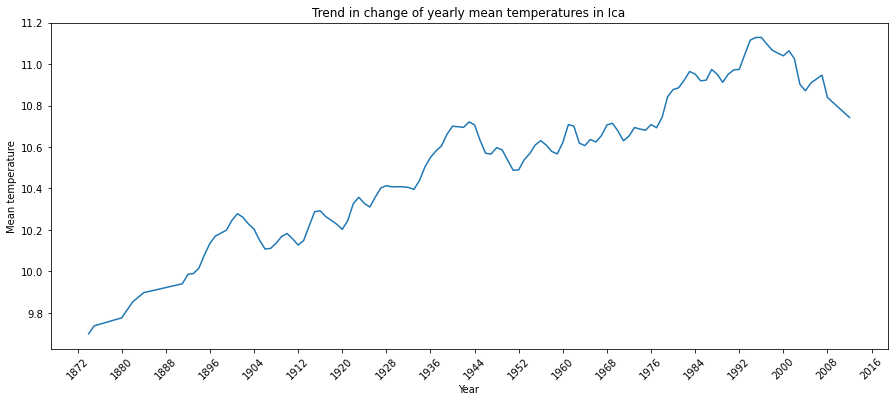

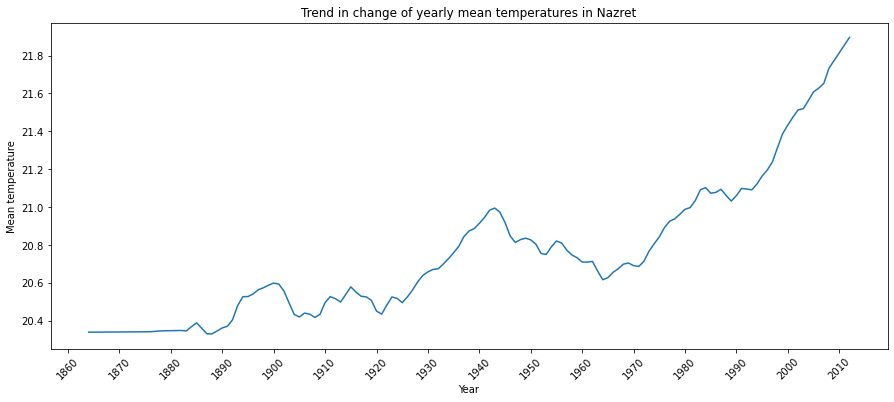

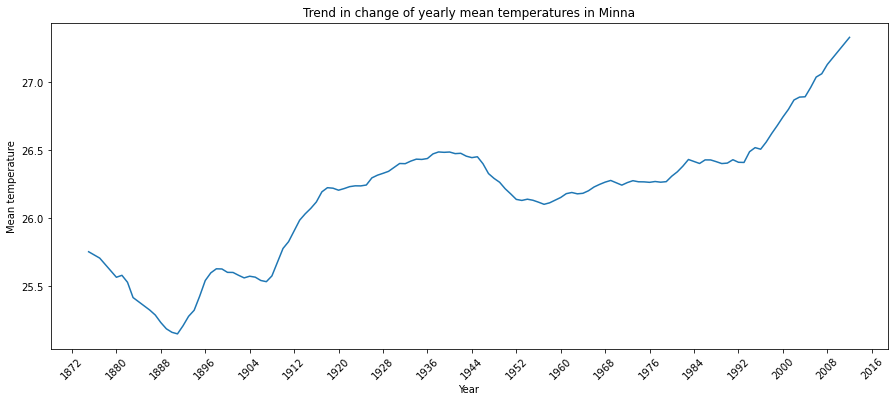

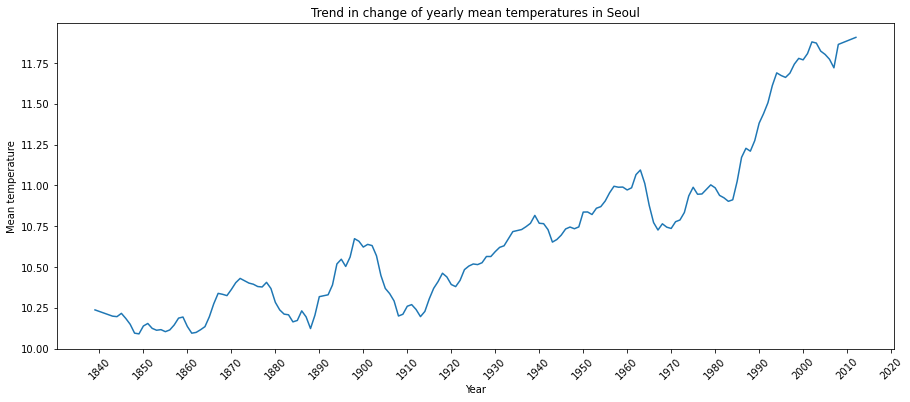

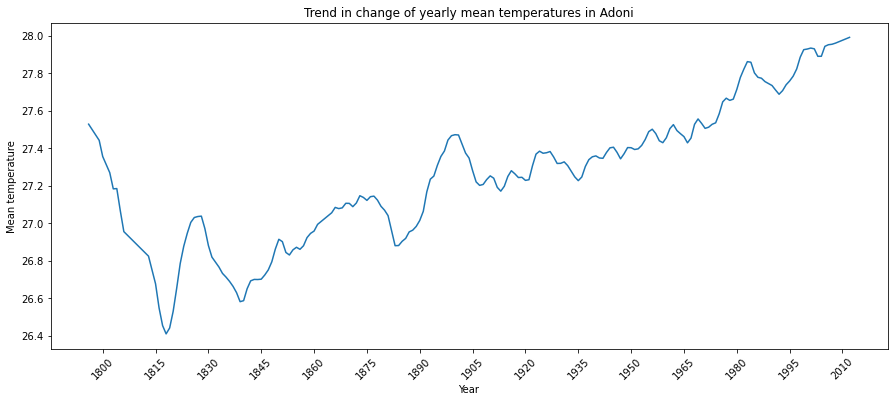

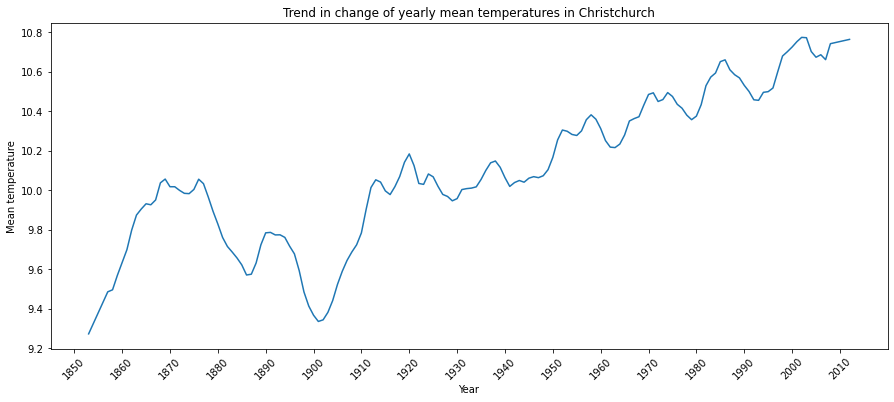

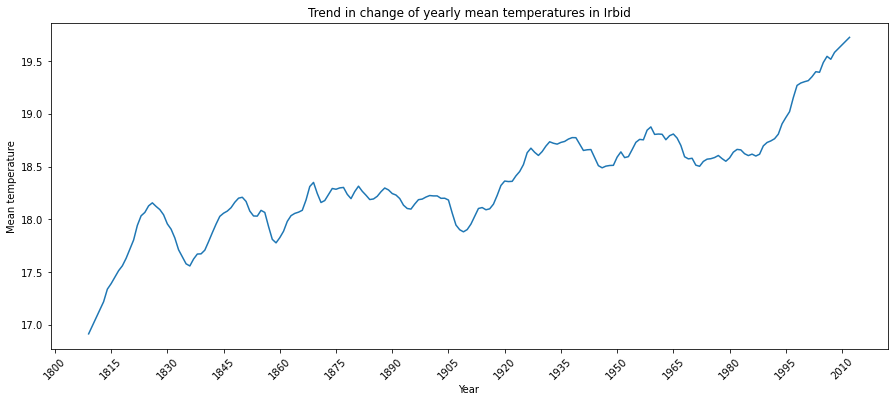

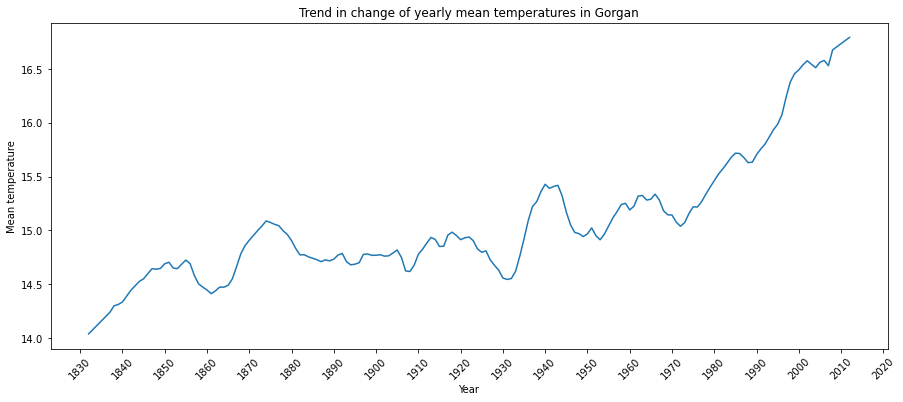

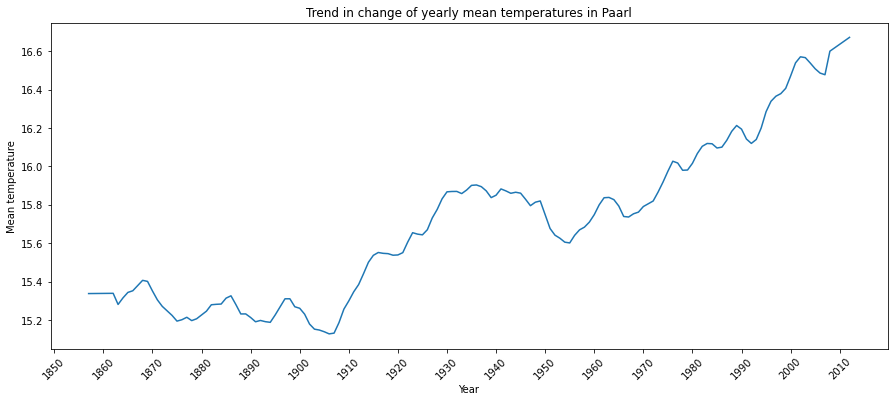

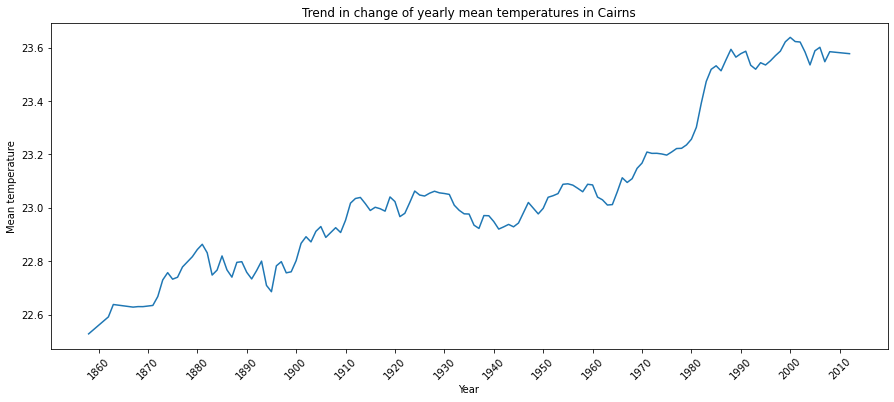

In [43]:
# plotting trends for each city

# iterating over cities
for key in cities_dict.keys():
    # creating yearly means
    data_city = cities_dict[key]
    yearly = data_city.groupby("year").mean()
    # decomposing timeseries
    result = seasonal_decompose(yearly.AverageTemperature, model='additive',period=10, extrapolate_trend='freq')    
    
    # plotting results
    plt.figure(figsize=(15,6))
    plt.plot(yearly.index, result.trend)
    plt.xlabel("Year")
    plt.ylabel("Mean temperature")
    # limiting number of x ticks showing
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(20))
    plt.xticks(rotation=45)
    plt.title(f"Trend in change of yearly mean temperatures in {key}")

plt.show()

Plots show clear rising trend over the years, in most of them rising sharply after 1980 and continuing to present. Only in Chicha Alta and Guadalupe there is small trend breakdown

# Now let's analyse Carbon Dioxide emission

In [44]:
greenhouse_gasses.gdp.isna().sum()

10912

In [45]:
# 10 biggest co2 polluters since 1900
# setting pandas display of numbers to float format
pd.options.display.float_format = '{:,.2f}'.format

# removing aggregates such as Europe from data
greenhouse = greenhouse_gasses[greenhouse_gasses.country.isin(data.Country.unique())]

# co2 emissions by country, removing 
total_co2_emission = greenhouse.groupby("country").sum().reset_index()
total_co2_emission[["country","co2"]].sort_values(by="co2",ascending=False).head(40)

country            co2
143         United States 404,769,397.00
27                  China 210,201,179.00
112                Russia 100,720,358.00
49                Germany  91,300,314.00
142        United Kingdom  77,448,896.00
68                  Japan  63,517,214.00
60                  India  51,196,387.00
45                 France  37,952,874.00
23                 Canada  32,517,775.00
106                Poland  27,232,403.00
140               Ukraine  25,895,961.00
66                  Italy  23,972,106.00
122          South Africa  20,271,068.00
85                 Mexico  19,378,657.00
6               Australia  17,781,722.00
62                   Iran  17,342,748.00
123           South Korea  16,497,584.00
17                 Brazil  14,605,075.00
114          Saudi Arabia  14,462,454.00
124                 Spain  14,374,585.00
61              Indonesia  12,914,154.00
13                Belgium  12,350,672.00
93            Netherlands  11,476,362.00
70             Kazakhstan  11,418,702.00
137                Turkey  10,056,441.00
111               Romania   8,419,147.00
131                Taiwan   8,261,278.00
4               Argentina   8,150,851.00
146             Venezuela   7,688,411.00
134              Thailand   6,855,547.00
38                  Egypt   5,880,282.00
145            Uzbekistan   5,850,730.00
81               Malaysia   5,474,227.00
7                 Austria   5,373,859.00
58                Hungary   4,920,336.00
128                Sweden   4,898,592.00
100              Pakistan   4,754,628.00
12                Belarus   4,581,041.00
141  United Arab Emirates   4,438,314.00
2                 Algeria   4,257,592.00

In [46]:
# merging data

total_co2_emission.rename({"country":"Country"},axis=1,inplace=True)
to_plt = map_df.merge(total_co2_emission, on="Country")

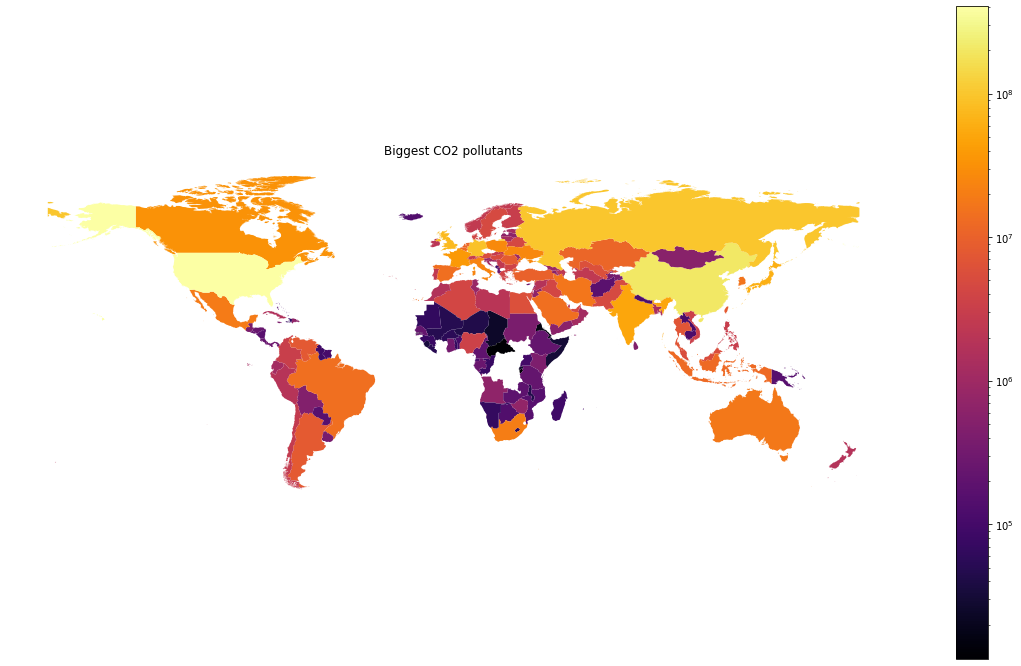

In [47]:
# plotting biggest pollutants historically
fig, ax = plt.subplots(1,figsize=(20,12))
to_plt.plot(column="co2",ax=ax,cmap="inferno",legend=True,norm=plt_c.LogNorm(vmin=to_plt.co2.min(), vmax=to_plt.co2.max()))
plt.title("Biggest CO2 pollutants")
ax.axis("off")
plt.show()

In [48]:
# specyfying data for next plot
total_co2_emission_1980 = greenhouse[greenhouse.year > 1980].groupby("country").sum().reset_index()
total_co2_emission_1980.rename({"country":"Country"},axis=1,inplace=True)
to_plt = map_df.merge(total_co2_emission_1980, on="Country")

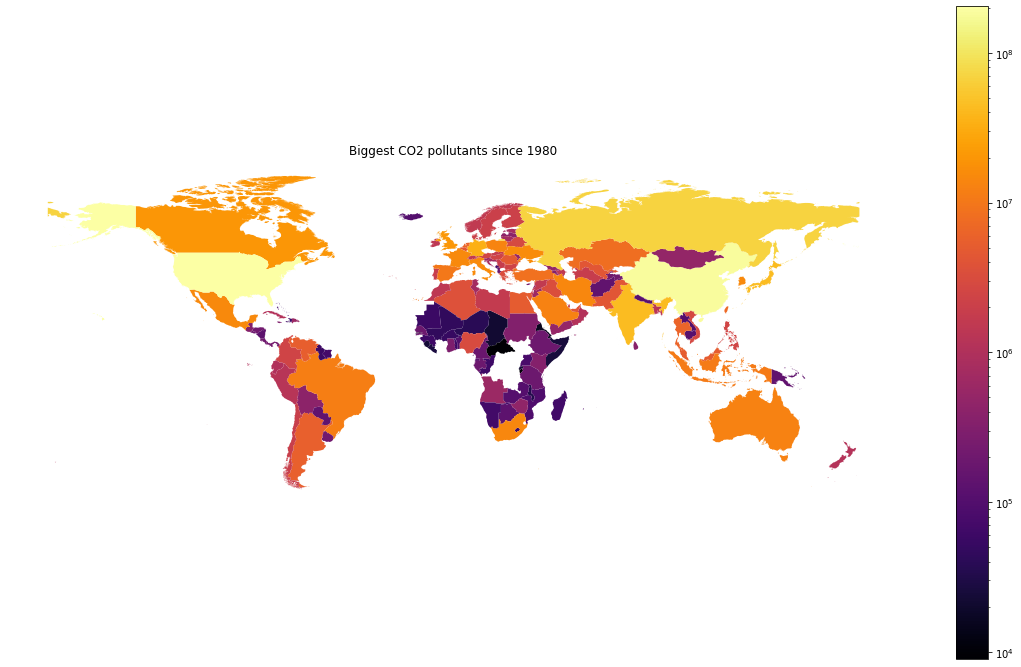

In [49]:
# plotting biggest polluters since 1990
fig, ax = plt.subplots(1,figsize=(20,12))
to_plt.plot(column="co2",ax=ax,cmap="inferno",legend=True,norm=plt_c.LogNorm(vmin=to_plt.co2.min(), vmax=to_plt.co2.max()),)
plt.title("Biggest CO2 pollutants since 1980")
ax.axis("off")
plt.show()

Historically, the biggest emitors are USA, Western European countries, Russia and China. Since 1990 China became the "leader" along the USA, but we must remember about population difference

In [50]:
# data from another source, let's compare

co2_emissions.groupby("Country").sum()["Total"].sort_values(ascending=False).head(40)

Country
UNITED STATES OF AMERICA                 102510260
CHINA (MAINLAND)                          47649834
USSR                                      30790355
UNITED KINGDOM                            20500813
JAPAN                                     14585037
GERMANY                                   12764185
INDIA                                     11385351
RUSSIAN FEDERATION                        10466421
FRANCE (INCLUDING MONACO)                  9697149
CANADA                                     8038299
FEDERAL REPUBLIC OF GERMANY                7492600
POLAND                                     6960097
ITALY (INCLUDING SAN MARINO)               6032718
SOUTH AFRICA                               5030416
MEXICO                                     4768665
AUSTRALIA                                  4252724
ISLAMIC REPUBLIC OF IRAN                   4028153
REPUBLIC OF KOREA                          3824538
SPAIN                                      3529437
BRAZIL                 

Countries with the biggest co2 emissions are mostly European and American developed nations, with China, RSA and Mexico who are rapidly developing

In [51]:
# methane emissions

greenhouse.groupby("country").sum()["methane"].sort_values(ascending=False).head(40)

country
China            24,919,180.00
Russia           21,225,520.00
United States    19,142,540.00
India            16,380,030.00
Brazil           10,191,580.00
Indonesia         9,858,370.00
Australia         4,106,560.00
Argentina         3,240,600.00
Canada            3,116,750.00
Ukraine           3,099,930.00
Mexico            3,096,150.00
Nigeria           2,959,270.00
Iran              2,923,520.00
Zambia            2,815,890.00
Pakistan          2,739,570.00
United Kingdom    2,626,730.00
Uzbekistan        2,605,150.00
Germany           2,288,750.00
Thailand          2,082,470.00
Venezuela         2,066,120.00
Bangladesh        1,949,110.00
Vietnam           1,914,410.00
France            1,905,370.00
Ethiopia          1,871,490.00
Libya             1,834,700.00
Colombia          1,804,980.00
Philippines       1,559,560.00
Tanzania          1,461,310.00
Poland            1,427,630.00
Italy             1,366,740.00
Angola            1,320,630.00
Egypt             1,254,980.00


Situation is a bit different with methane, as generally biggest nations produce more of it

In [52]:
# Nitrous oxide

greenhouse.groupby("country").sum()["nitrous_oxide"].sort_values(ascending=False).head(40)

country
China                      11,448,130.00
United States               7,073,970.00
India                       5,365,610.00
Brazil                      3,983,010.00
Indonesia                   2,230,600.00
Australia                   2,212,020.00
Russia                      1,973,320.00
Cameroon                    1,474,040.00
France                      1,321,050.00
Germany                     1,297,070.00
Canada                      1,253,170.00
Argentina                   1,157,390.00
Pakistan                    1,146,340.00
Mexico                      1,029,510.00
United Kingdom              1,026,390.00
Ethiopia                      918,310.00
Iran                          846,060.00
Zambia                        775,950.00
Nigeria                       772,390.00
Turkey                        761,790.00
Central African Republic      727,640.00
Italy                         664,930.00
Tanzania                      664,140.00
Sudan                         654,490.00
Japan   

### Let's see how emission levels changed over the years in the world and in some countries with biggest emissions

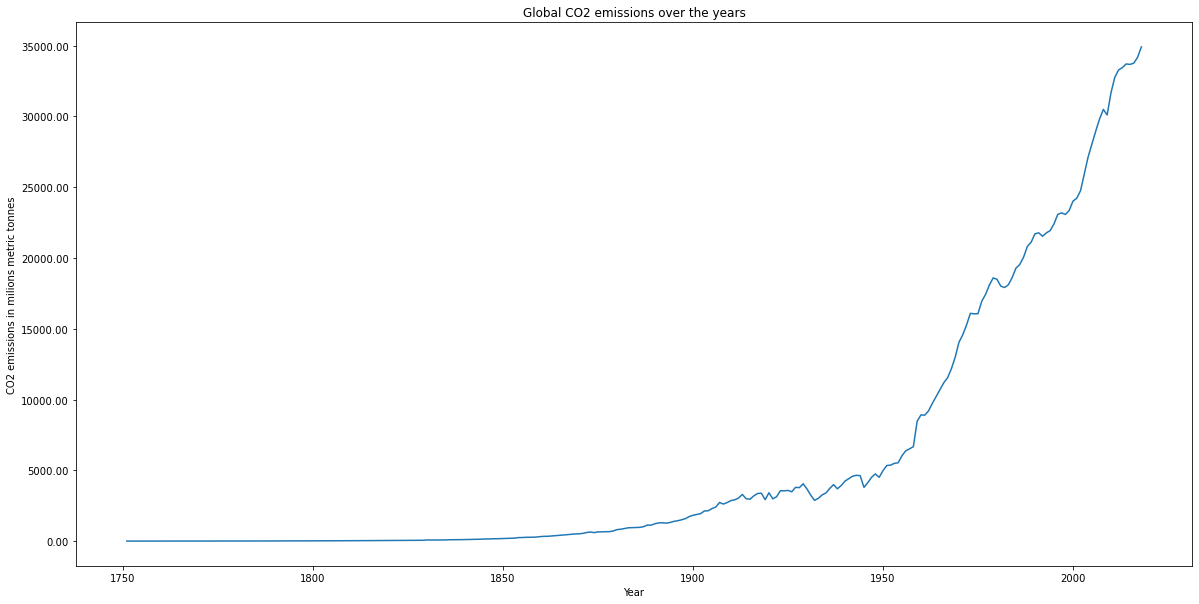

In [53]:
# plotting global co2 emission changes

greenhouse_yearly = greenhouse.groupby("year")["co2"].sum()

fig, ax = plt.subplots(figsize=(20,10))
plt.plot(greenhouse_yearly.index,greenhouse_yearly/1000)
plt.xlabel("Year")
plt.ylabel("CO2 emissions in milions metric tonnes")
plt.title("Global CO2 emissions over the years")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
plt.show()


Global co2 emissions are rising sharply since 1950s, and as for 2018 there seems to be no visible trend breakdown.

Let's focus on the biggest pollutants: USA, China, Russia, Germany and UK

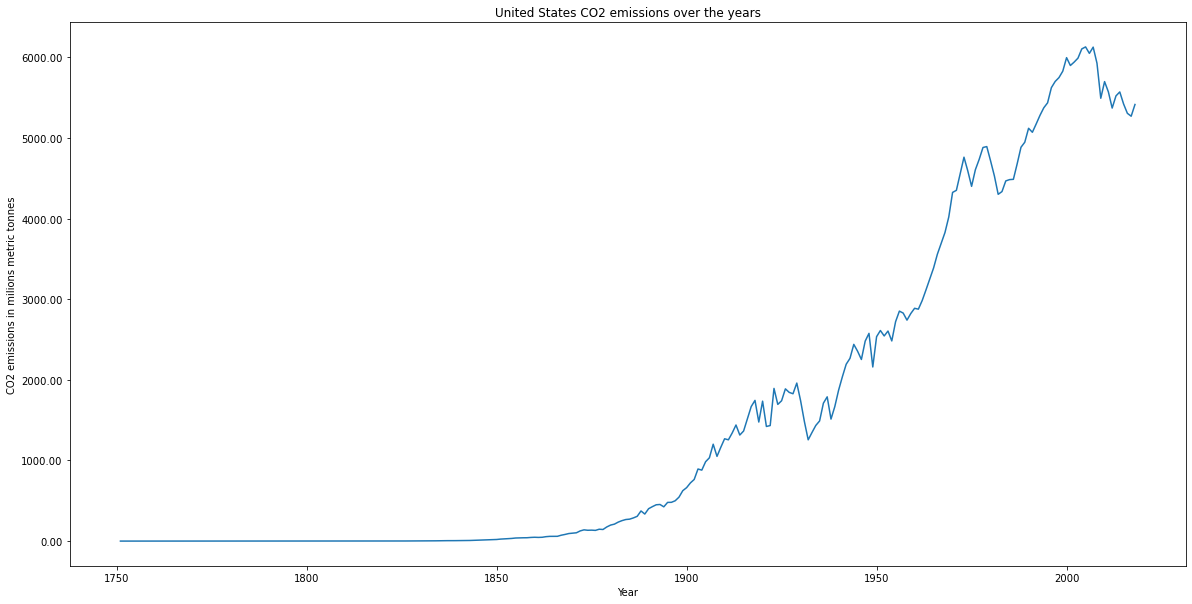

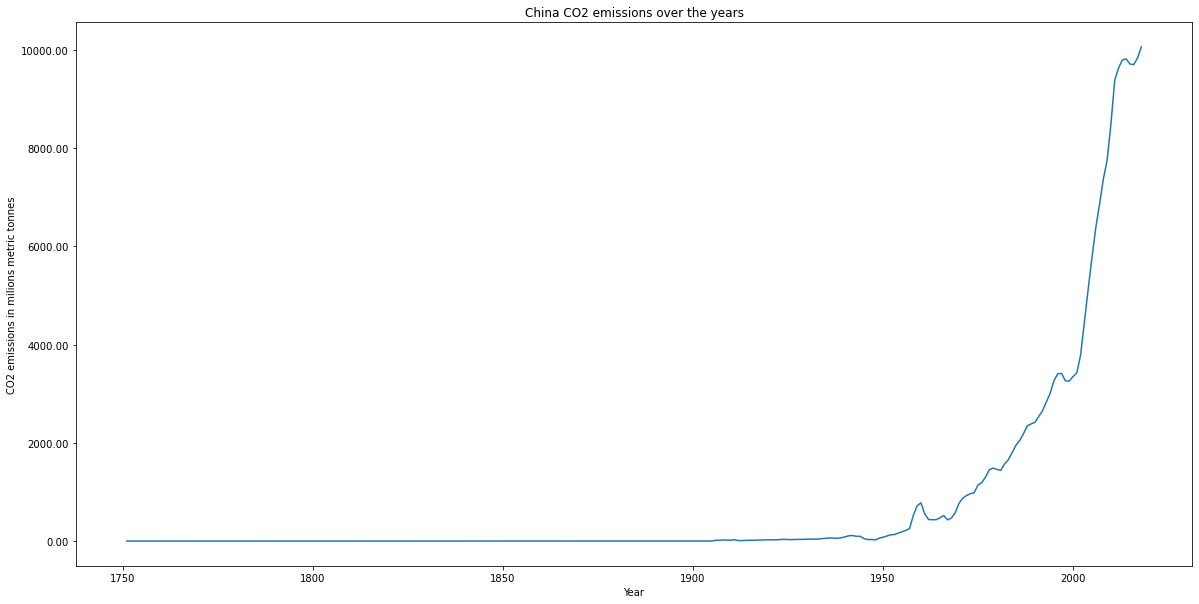

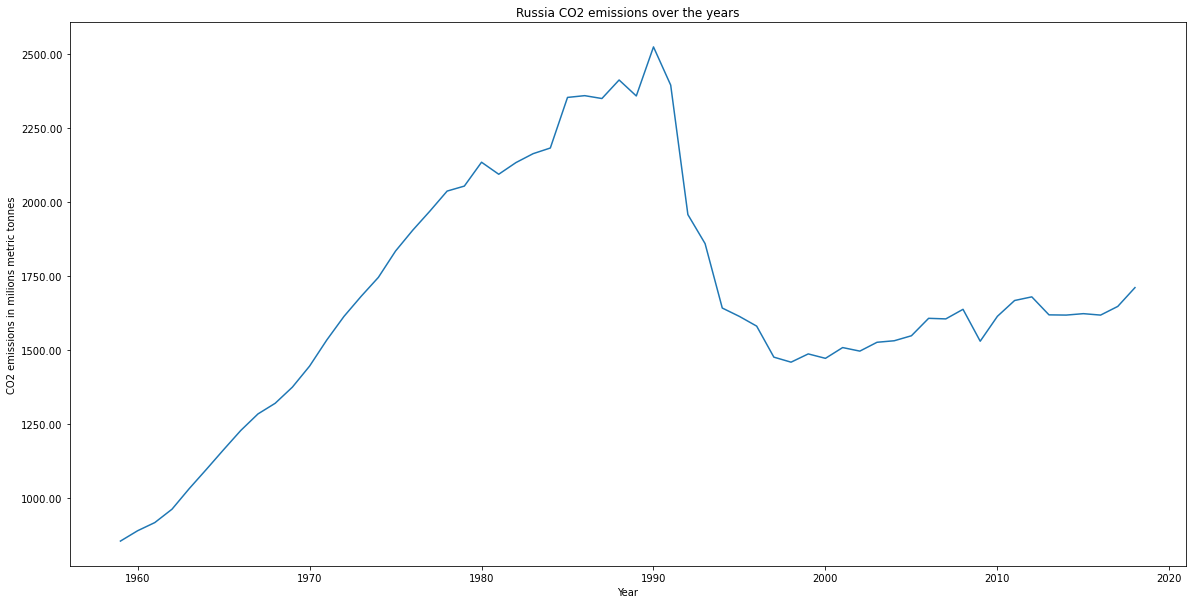

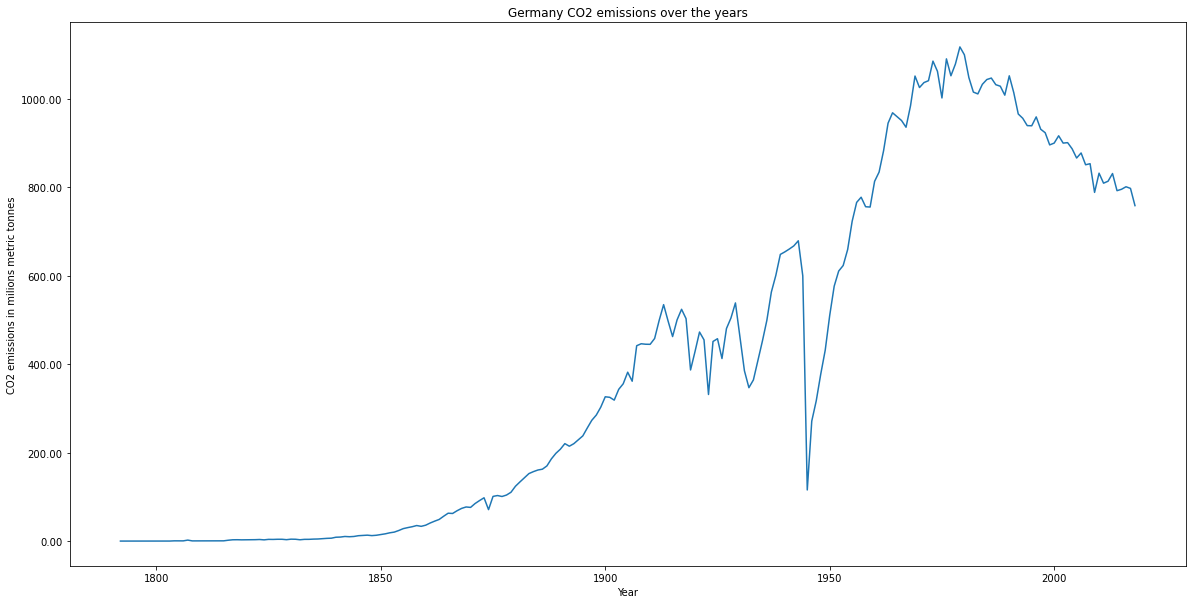

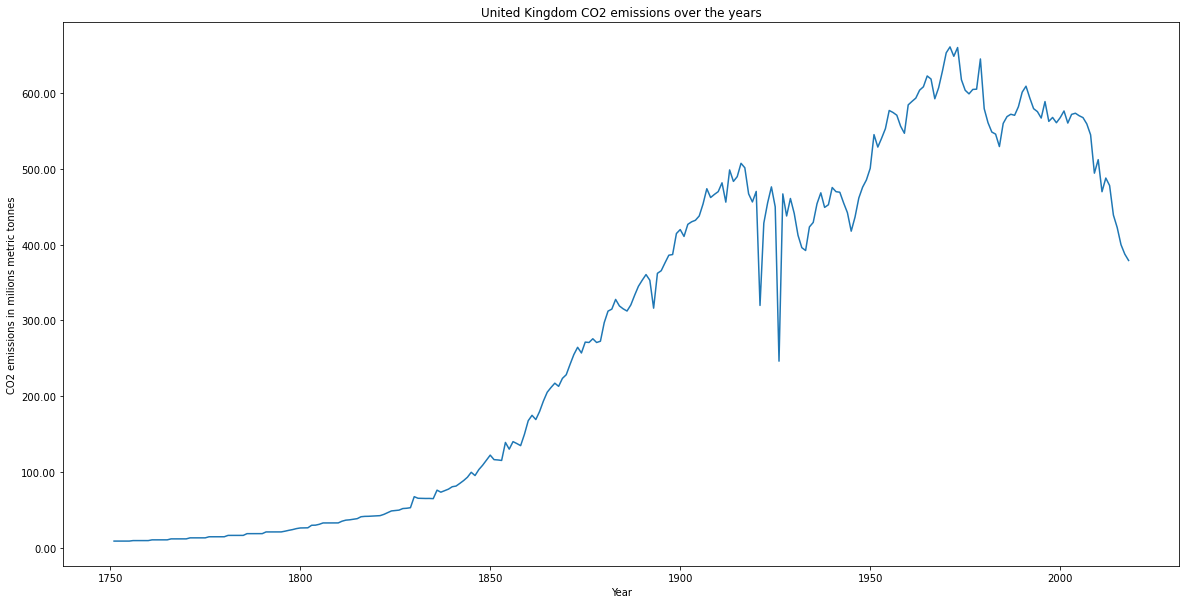

In [54]:
# plotting co2 emissions changes in most polluting countries
countries = ["United States","China","Russia","Germany","United Kingdom"]

for country in countries:
    grouped = greenhouse[greenhouse.country == country].groupby("year")["co2"].sum()

    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(grouped.index,grouped/1000)
    plt.xlabel("Year")
    plt.ylabel("CO2 emissions in milions metric tonnes")
    plt.title(f"{country} CO2 emissions over the years")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.show()
    
    


US emissions have stalled and even delicately fell from 2000. Germany, UK have started to cut their emissions from around 1990 but they remained high. Russia's emissions fell dramatically in 1990, after Soviet Unions' collapse, and stayed on around the same level since (around three times higher than UK). China's emissions continue to rise dramatically.

Let's find out where emissions keep on rising and where they are starting to fall. We'll consider data since 1990.

In [55]:
greenhouse[greenhouse.year > 1990].groupby("country")["co2_growth_prct"].mean().sort_values(ascending=False).head(50)

country
Cameroon               170.51
Eritrea                135.15
Equatorial Guinea       44.26
Laos                    15.73
Haiti                   14.55
Angola                  12.19
Nepal                   10.95
Benin                    9.38
Mozambique               9.37
Qatar                    9.12
Vietnam                  8.71
Mali                     8.26
Cambodia                 8.13
Afghanistan              7.90
Uganda                   7.80
Burkina Faso             7.23
Congo                    7.16
Oman                     7.13
Tanzania                 7.04
Sri Lanka                6.96
Bangladesh               6.74
Togo                     6.73
Ghana                    6.41
Ethiopia                 6.38
Sudan                    6.37
Iraq                     6.34
Madagascar               6.28
Namibia                  6.24
Panama                   6.20
Nigeria                  6.10
Reunion                  5.92
Indonesia                5.83
Malaysia                 5.82
Un

In [56]:
greenhouse[greenhouse.year > 1990].groupby("country")["co2_growth_prct"].mean().sort_values().head(50)

country
Moldova          -4.96
Ukraine          -3.75
Latvia           -3.22
Romania          -2.68
Lithuania        -2.65
Slovakia         -1.81
Bulgaria         -1.61
United Kingdom   -1.57
Estonia          -1.51
Belarus          -1.47
Hungary          -1.29
Russia           -1.25
Denmark          -1.14
Germany          -1.12
Sweden           -1.11
Italy            -0.88
Azerbaijan       -0.76
Armenia          -0.74
Belgium          -0.61
Switzerland      -0.58
Croatia          -0.57
France           -0.56
Uzbekistan       -0.51
Greece           -0.35
Finland          -0.31
Poland           -0.28
Syria            -0.21
Slovenia         -0.07
Somalia          -0.06
Cuba             -0.05
Netherlands       0.03
Japan             0.05
Georgia           0.06
Tajikistan        0.09
Serbia            0.18
United States     0.23
Zimbabwe          0.43
Austria           0.44
Portugal          0.56
Jamaica           0.60
Spain             0.67
Ireland           0.69
Canada            0.77
Gab

All of the countries with big emission rises are developing countries, while most of the countries with emission falls are Post-Communist countries (probably because the fall in industrial production after the USSR collapse) and Western European countries trying to scale down their emissions to protect climate.

Let's examine the link between emissions and GDP rise more closely

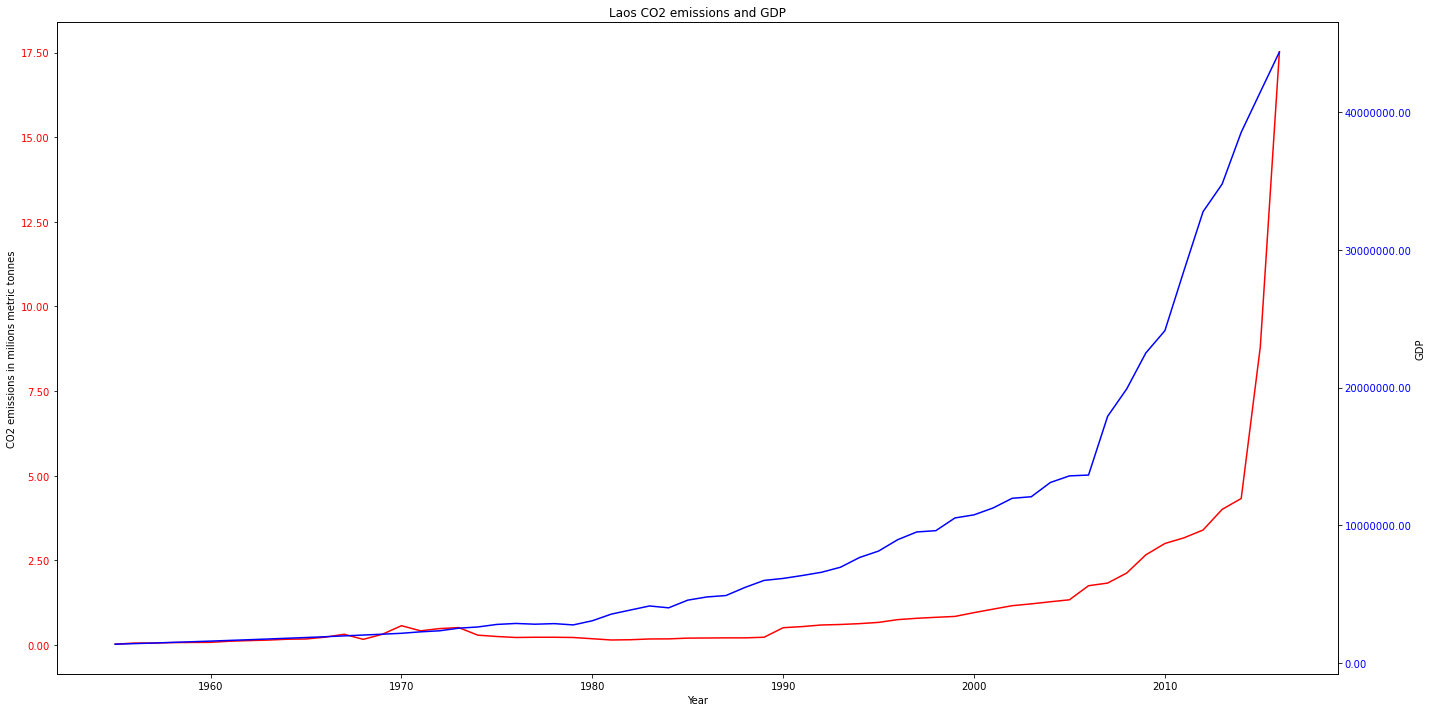

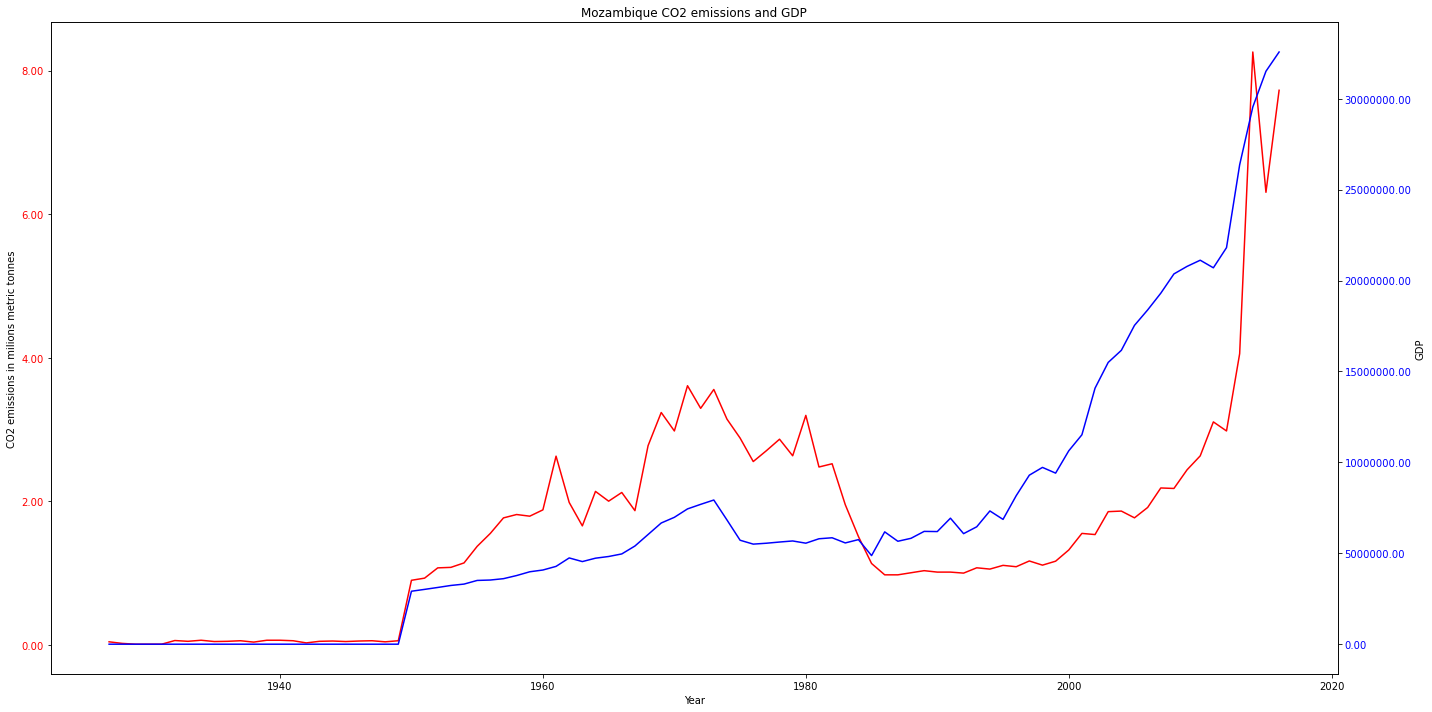

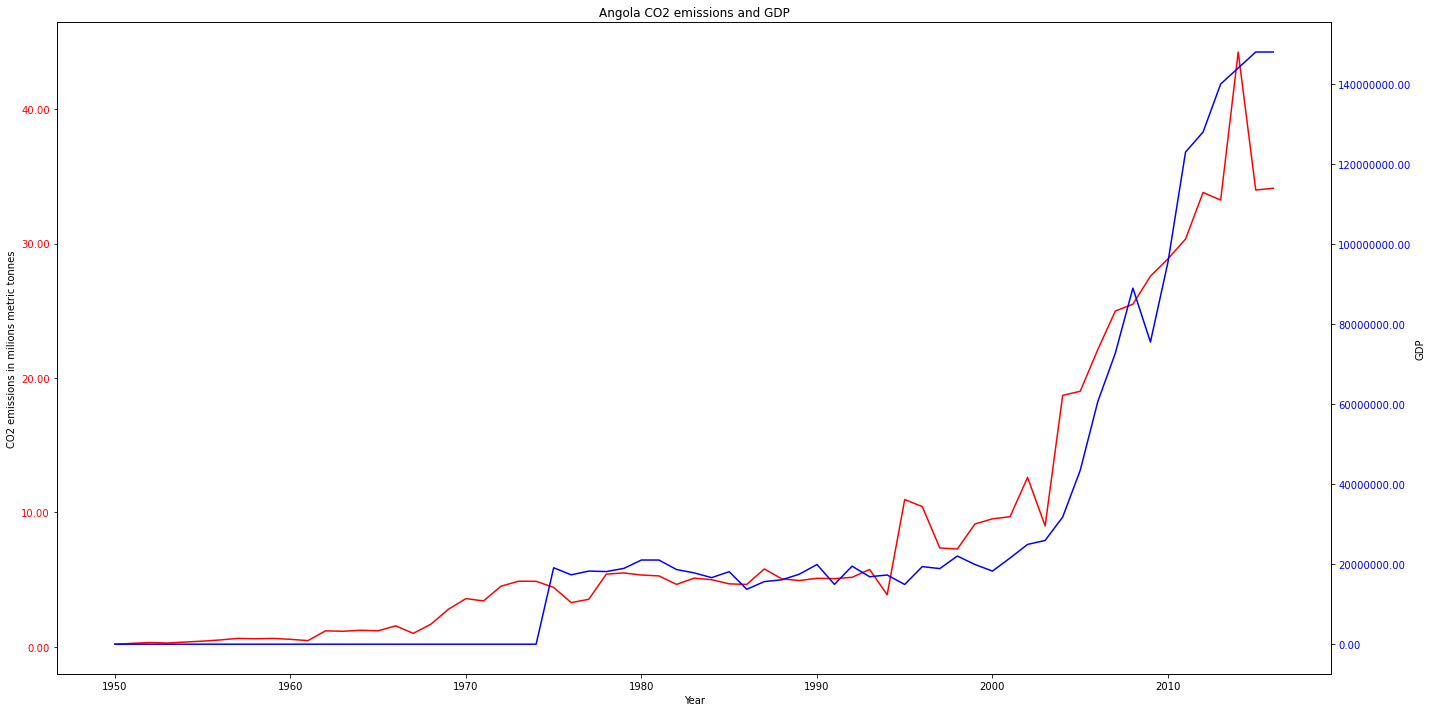

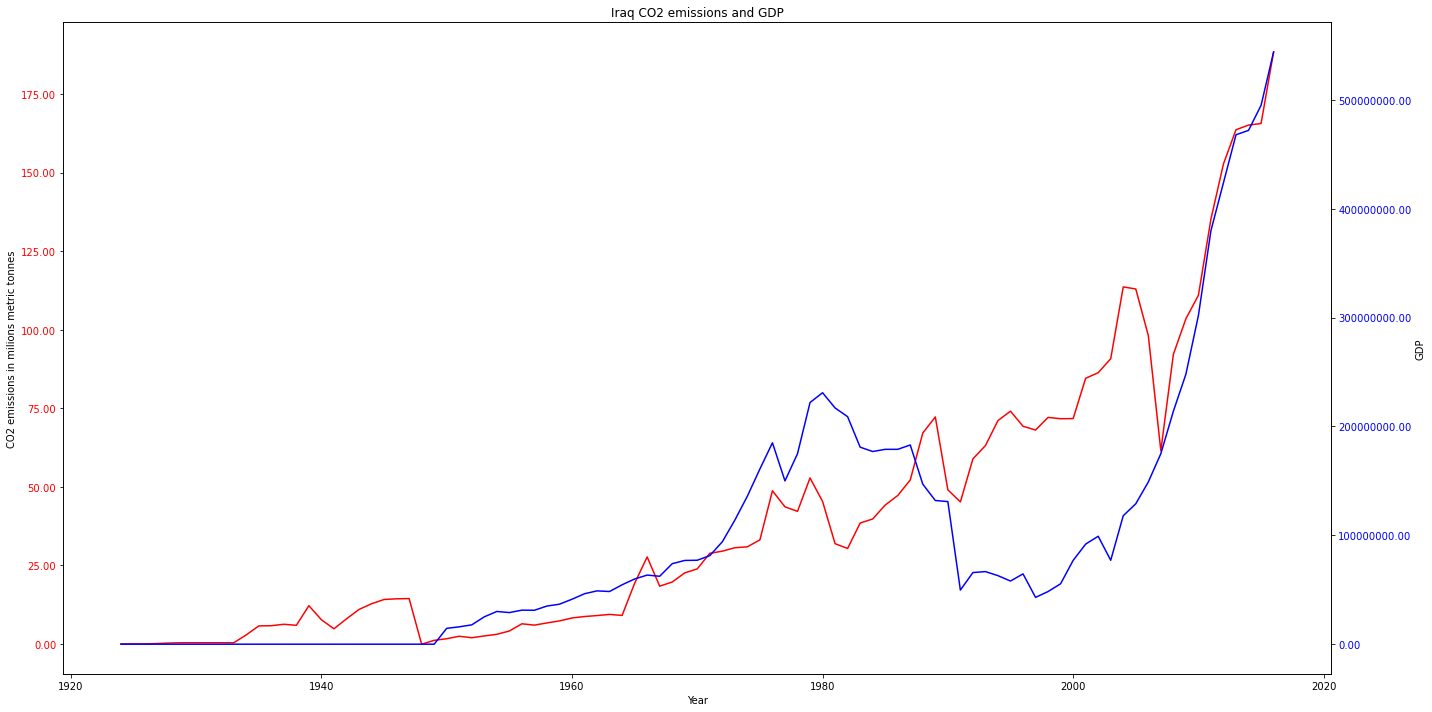

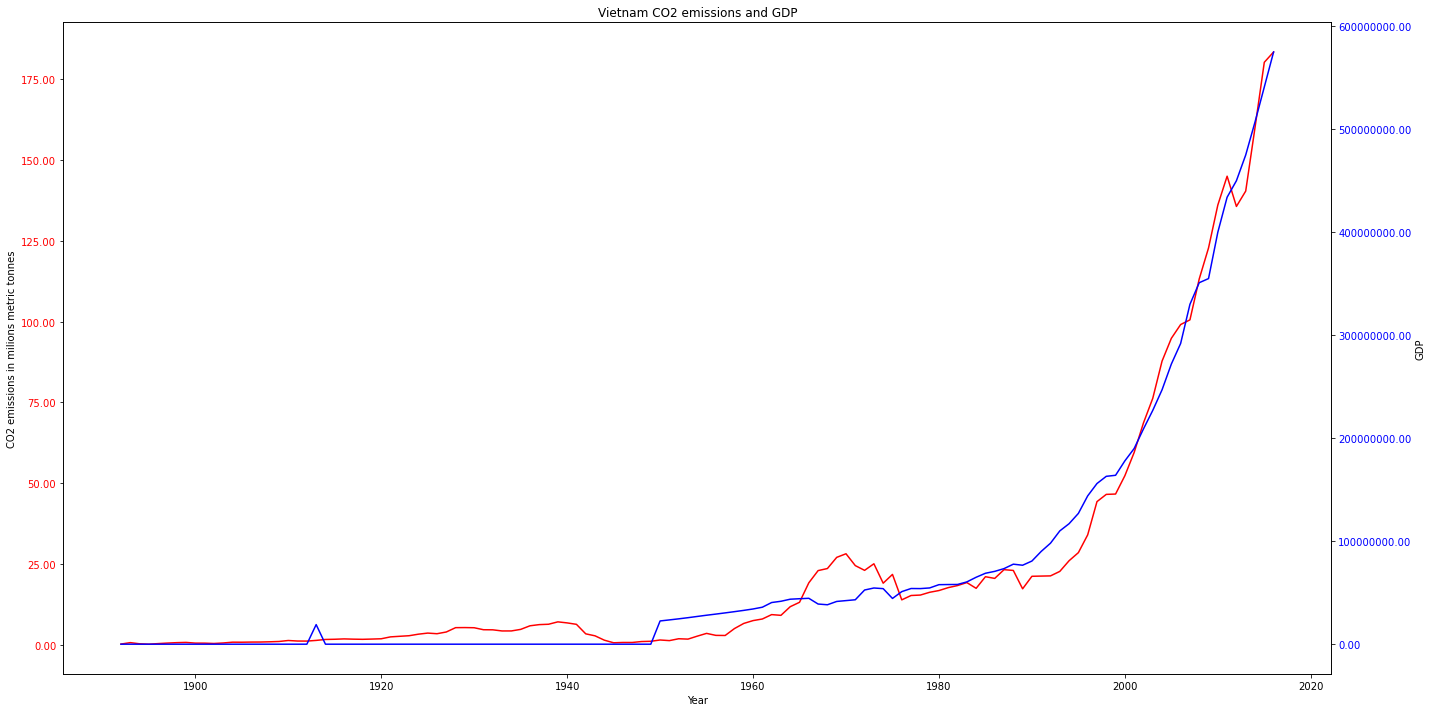

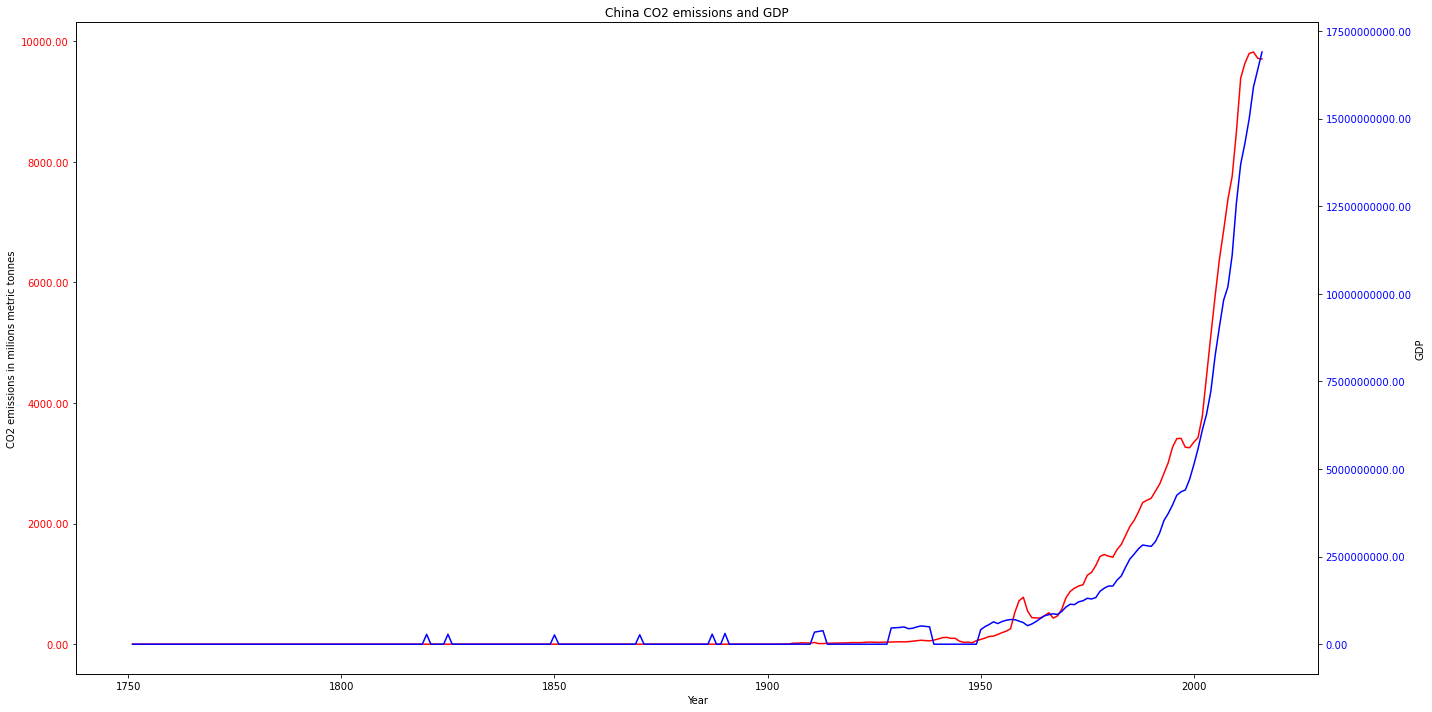

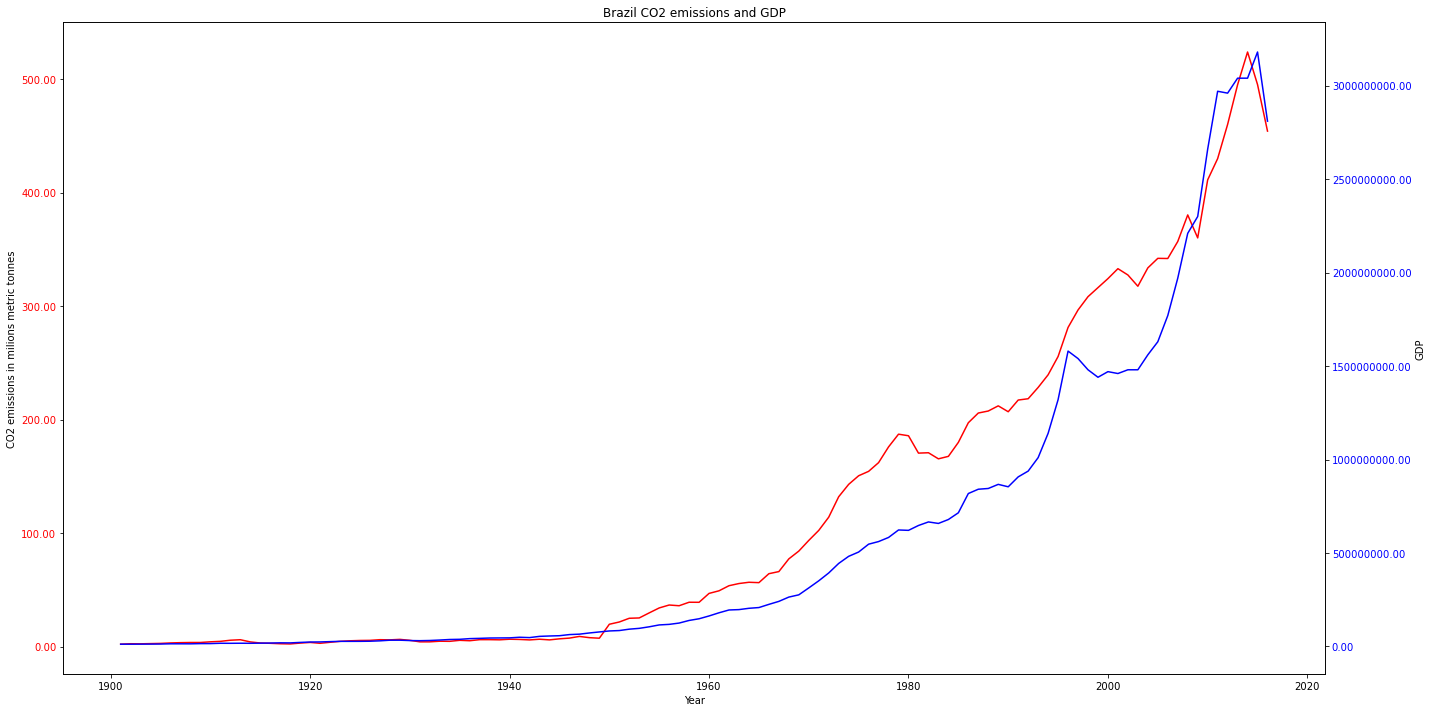

In [57]:
# Choosing some of the countries with highest mean emission raise, China and Brazil as rapidly developping big countries

countries = ["Laos","Mozambique","Angola","Iraq","Vietnam","China","Brazil"]

for country in countries:
    grouped = greenhouse[(greenhouse.country == country)&(greenhouse.year<2017)].groupby("year").sum()

    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(grouped.index,grouped["co2"].dropna()/1000,color="red")
    ax.set_xlabel("Year")
    ax.set_ylabel("CO2 emissions in milions metric tonnes")
    ax.set_title(f"{country} CO2 emissions and GDP")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax.tick_params(axis='y', labelcolor="red")

    ax1 = ax.twinx()
    ax1.plot(grouped.index,grouped["gdp"].dropna()/1000,color="blue")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("GDP")
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.tick_params(axis='y', labelcolor="blue")

    
    fig.tight_layout()
    plt.show()

As this set of plots show, gdp growth is also heavily correlated with co2 emissions. 

Let's find out how the atmospheric concentration levels of co2 and other greenhouse gases has changed over the years. This data is in parts per million (or billion) format.

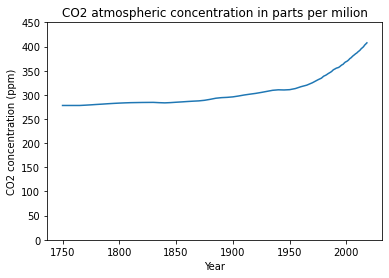

In [58]:


plt.plot(concentration.iloc[:,1],concentration["CO2 (ppm)"])
plt.ylim(0,450)
plt.xlabel("Year")
plt.ylabel("CO2 concentration (ppm)")
plt.title("CO2 atmospheric concentration in parts per milion")
plt.show()

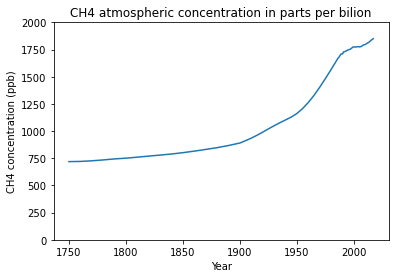

In [59]:
plt.plot(concentration.iloc[:,1],concentration["CH4 (ppb)"])
plt.xlabel("Year")
plt.ylim(0,2000)
plt.ylabel("CH4 concentration (ppb)")
plt.title("CH4 atmospheric concentration in parts per bilion")
plt.show()

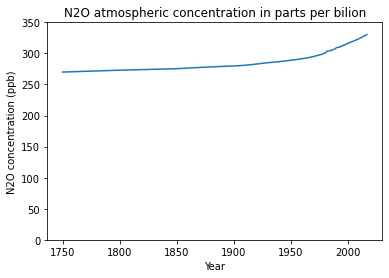

In [60]:
plt.plot(concentration.iloc[:,1],concentration["N2O (ppb)"])
plt.xlabel("Year")
plt.ylim(0,350)
plt.ylabel("N2O concentration (ppb)")
plt.title("N2O atmospheric concentration in parts per bilion")
plt.show()

Trends in atmospheric concentration of greenhouse gases are in line with trends in emissions. Let's plot them alongside

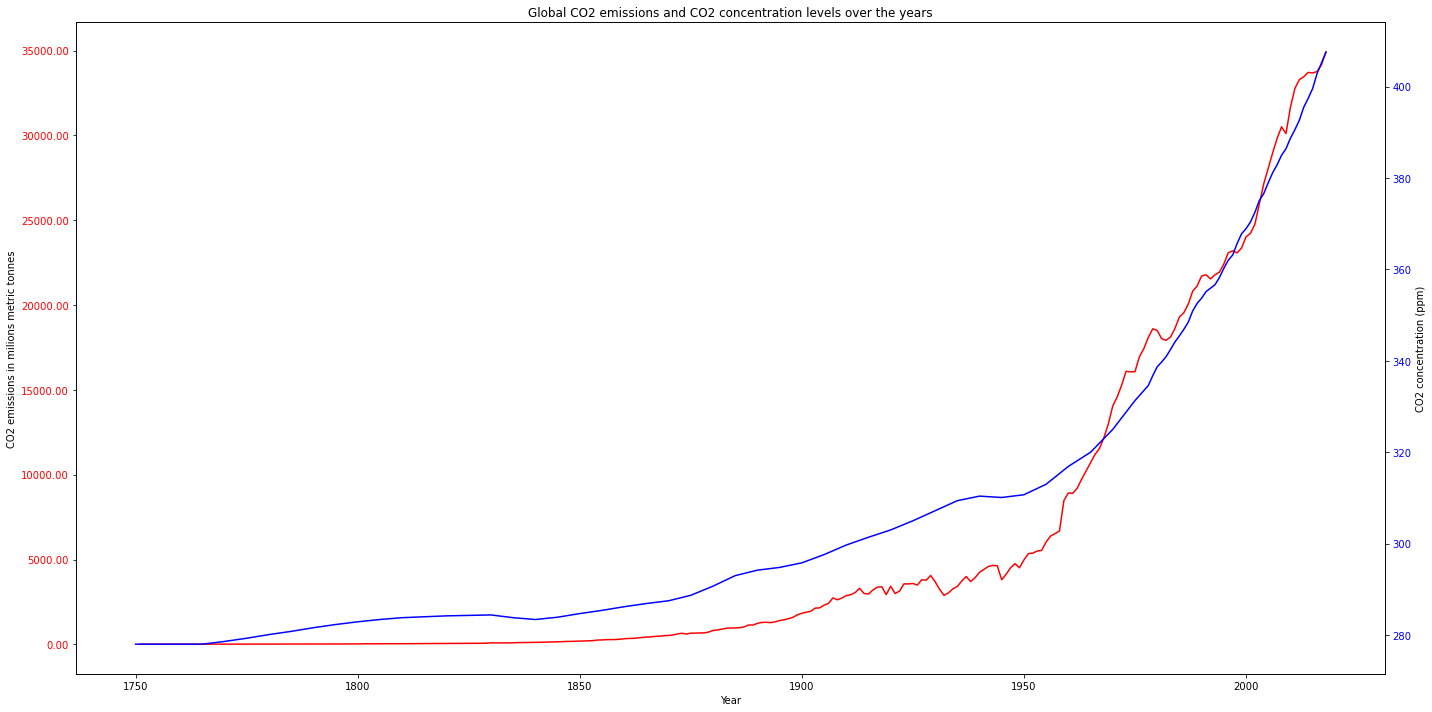

In [61]:
greenhouse_yearly = greenhouse.groupby("year")["co2"].sum()

fig, ax = plt.subplots(figsize=(20,10))
ax.plot(greenhouse_yearly.index,greenhouse_yearly/1000,color="red")
ax.set_xlabel("Year")
ax.set_ylabel("CO2 emissions in milions metric tonnes")
ax.set_title("Global CO2 emissions and CO2 concentration levels over the years")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
ax.tick_params(axis='y', labelcolor="red")


ax1 = ax.twinx()
ax1.plot(concentration.iloc[:,1],concentration["CO2 (ppm)"],color="blue")
ax1.set_xlabel("Year")
ax1.set_ylabel("CO2 concentration (ppm)")
ax1.tick_params(axis='y', labelcolor="blue")

fig.tight_layout()
plt.show()


The connection almost cannot be clearer. Human greenhouse gases emissions are rising alongside rising levels of CO2 concentration in atmosphere. I think we can exaggagerate a bit and say that this single plot anwsers the question of human influence on climate change.

To clear the image even more let's now plot the CO2 concentration levels along temperature rise

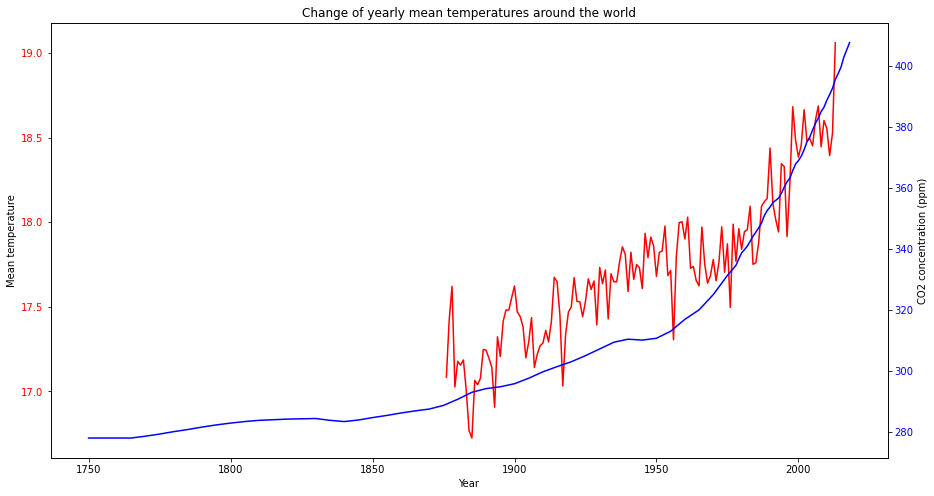

In [62]:
# grouping data
yearly_world = data.groupby("year").mean()
yearly_world = yearly_world[yearly_world.index > 1875]

fig,ax= plt.subplots(figsize=(15,8))
# plotting
ax.plot(yearly_world.index, yearly_world.AverageTemperature,color="red")
ax.set_xlabel("Year")
ax.set_ylabel("Mean temperature")
ax.tick_params(axis='y', labelcolor="red")


ax1 = ax.twinx()
ax1.plot(concentration.iloc[:,1],concentration["CO2 (ppm)"],color="blue")
ax1.set_ylabel("CO2 concentration (ppm)")
ax1.tick_params(axis='y', labelcolor="blue")


plt.xticks(rotation=45)
plt.title("Change of yearly mean temperatures around the world")
plt.show()

## Forestation and emissions from land use

Last element of this analysis is to investigate the issue of deforestation. Forests are natual CO2 capture system, removing CO2 from the atmosphere and releasing oxygen instead. Because of this, deforestation drives the climate change, as less and less CO2 is being captured by them.

First, let's look at the data concerning CO2 emissions from land use. These numbers are estimates of how various human actions, such as forestry, farming and cultivating crops contribute yearly to global co2 emissions. 

In [63]:
forestation

Domain Code          Domain  Area Code         Area  Element Code  \
0              GL  Land Use Total          2  Afghanistan          7233   
1              GL  Land Use Total          2  Afghanistan          7233   
2              GL  Land Use Total          2  Afghanistan          7233   
3              GL  Land Use Total          2  Afghanistan          7233   
4              GL  Land Use Total          2  Afghanistan          7233   
...           ...             ...        ...          ...           ...   
45958          GL  Land Use Total        181     Zimbabwe          7244   
45959          GL  Land Use Total        181     Zimbabwe          7244   
45960          GL  Land Use Total        181     Zimbabwe          7244   
45961          GL  Land Use Total        181     Zimbabwe          7244   
45962          GL  Land Use Total        181     Zimbabwe          7244   

                            Element  Item Code             Item  Year Code  \
0      Net emissions/removals (CO2)       5065      Forest land       1990   
1      Net emissions/removals (CO2)       5065      Forest land       1991   
2      Net emissions/removals (CO2)       5065      Forest land       1992   
3      Net emissions/removals (CO2)       5065      Forest land       1993   
4      Net emissions/removals (CO2)       5065      Forest land       1994   
...                             ...        ...              ...        ...   
45958    Emissions (CO2eq) from CH4       5069  Burning Biomass       2015   
45959    Emissions (CO2eq) from CH4       5069  Burning Biomass       2016   
45960    Emissions (CO2eq) from CH4       5069  Burning Biomass       2017   
45961    Emissions (CO2eq) from CH4       5069  Burning Biomass       2018   
45962    Emissions (CO2eq) from CH4       5069  Burning Biomass       2019   

       Year       Unit     Value Flag  \
0      1990  gigagrams -2,388.80    A   
1      1991  gigagrams -2,388.80    A   
2      1992  gigagrams -2,388.80    A   
3      1993  gigagrams -2,388.80    A   
4      1994  gigagrams -2,388.80    A   
...     ...        ...       ...  ...   
45958  2015  gigagrams    116.00    A   
45959  2016  gigagrams     94.00    A   
45960  2017  gigagrams     53.00    A   
45961  2018  gigagrams     89.00    A   
45962  2019  gigagrams    108.00    A   

                                        Flag Description  
0      Aggregate, may include official, semi-official...  
1      Aggregate, may include official, semi-official...  
2      Aggregate, may include official, semi-official...  
3      Aggregate, may include official, semi-official...  
4      Aggregate, may include official, semi-official...  
...                                                  ...  
45958  Aggregate, may include official, semi-official...  
45959  Aggregate, may include official, semi-official...  
45960  Aggregate, may include official, semi-official...  
45961  Aggregate, may include official, semi-official...  
45962  Aggregate, may include official, semi-official...  

[45963 rows x 14 columns]

In [64]:
forestation.Element.unique()

array(['Net emissions/removals (CO2)', 'Net emissions/removals (CO2eq)',
       'Emissions (CO2eq) from N2O', 'Emissions (CO2eq) from CH4'],
      dtype=object)

We are interested in Net emissions/removal of co2 and co2eq

In [65]:
forestation.Item.unique()

array(['Forest land', 'Burning Biomass', 'Cropland', 'Grassland'],
      dtype=object)

Data contain four main sources of emissions/removal, shown above. First, let's consider them separately, than together

In [66]:
# countries with biggest net removal of CO2
pd.options.display.float_format = '{:,.2f}'.format


co2_capture_by_country = forestation[forestation.Item == "Forest land"].groupby("Area").sum().Value.reset_index().rename({"Value":"capture"},axis=1)
co2_capture_by_country

Area      capture
0       Afghanistan   -51,340.57
1           Albania   -35,489.34
2           Algeria   -40,163.72
3    American Samoa    -2,596.76
4           Andorra         0.00
..              ...          ...
221  Western Sahara   -21,973.73
222           Yemen         0.00
223    Yugoslav SFR   -41,814.15
224          Zambia   494,980.53
225        Zimbabwe 1,258,130.11

[226 rows x 2 columns]

Let's now see the difference between co2 captured by forests and emited for each country, using data from earlier sections.

In [68]:
total_co2_emission

Country    year          co2  co2_growth_prct  co2_growth_abs  \
0    Afghanistan  138845   176,885.00         1,119.07            9.43   
1        Albania  169893   276,683.00         1,616.05            4.56   
2        Algeria  214016 4,257,592.00         1,801.54          155.72   
3         Angola  136896   666,452.00           828.99           34.34   
4      Argentina  257730 8,150,851.00           728.50          194.44   
..           ...     ...          ...              ...             ...   
146    Venezuela  212155 7,688,411.00            92.29          138.76   
147      Vietnam  248285 3,378,195.00         1,096.96          206.44   
148        Yemen  136896   604,862.00         6,748.04           10.08   
149       Zambia  119310   193,129.00            48.22            0.66   
150     Zimbabwe  209832   718,364.00           610.26           12.15   

     consumption_co2  trade_co2  trade_co2_share  co2_per_capita  \
0               0.00       0.00             0.00            9.13   
1             132.15      27.01           744.60          107.93   
2               0.00       0.00             0.00          155.04   
3               0.00       0.00             0.00           39.98   
4           4,161.34    -236.68          -161.09          292.55   
..               ...        ...              ...             ...   
146         3,132.20  -1,311.14          -827.11          498.10   
147         2,688.49     234.77           193.23           50.10   
148             0.00       0.00             0.00           44.80   
149           150.51      76.29         2,915.48           32.00   
150           398.10      55.83           453.31          109.97   

     consumption_co2_per_capita  ...  ghg_per_capita      methane  \
0                          0.00  ...           33.15   643,030.00   
1                         43.54  ...           76.61    95,540.00   
2                          0.00  ...          115.54 1,071,500.00   
3                          0.00  ...          258.49 1,320,630.00   
4                        107.63  ...          288.88 3,240,600.00   
..                          ...  ...             ...          ...   
146                      120.68  ...          352.32 2,066,120.00   
147                       31.07  ...           46.24 1,914,410.00   
148                        0.00  ...           34.36   167,180.00   
149                       12.53  ...        1,117.58 2,815,890.00   
150                       33.43  ...          151.88   296,520.00   

     methane_per_capita  nitrous_oxide  nitrous_oxide_per_capita  \
0                 23.79     128,440.00                      5.34   
1                 31.12      33,110.00                     10.80   
2                 32.32     197,690.00                      5.92   
3                 72.55     541,490.00                     30.25   
4                 85.52   1,157,390.00                     30.43   
..                  ...            ...                       ...   
146               82.40     339,820.00                     13.46   
147               23.11     508,350.00                      6.15   
148                8.57      74,440.00                      3.93   
149              252.87     775,950.00                     72.11   
150               24.50     170,070.00                     14.06   

     primary_energy_consumption  energy_per_capita  energy_per_gdp  \
0                          0.00               0.00            0.00   
1                      1,102.70         382,746.72           88.94   
2                     13,824.55         477,672.95           49.98   
3                      3,314.77         222,994.68          118.02   
4                     30,694.28         913,853.37           62.62   
..                          ...                ...             ...   
146                   31,091.15       1,486,398.34          165.99   
147                   10,859.41         139,435.48           61.79   
148                    1,71

In [70]:
# emissions by country
emissions_by_country = pd.Series(total_co2_emission["co2"].values,index=total_co2_emission["Country"])


In [71]:
# df with countries in both data frames
emission_capture = co2_capture_by_country[co2_capture_by_country.Area.isin(emissions_by_country.index)]

In [72]:
emissions_by_country = emissions_by_country[emissions_by_country.index.isin(emission_capture.Area)]

In [73]:
emission_capture["emission"] = emissions_by_country.values

In [74]:
emission_capture

Area      capture     emission
0    Afghanistan   -51,340.57   176,885.00
1        Albania   -35,489.34   276,683.00
2        Algeria   -40,163.72 4,257,592.00
5         Angola 1,553,049.27   666,452.00
6      Argentina 3,588,591.59 8,150,851.00
..           ...          ...          ...
216      Uruguay  -582,016.42   359,766.00
217   Uzbekistan  -304,550.93 5,850,730.00
222        Yemen         0.00   604,862.00
224       Zambia   494,980.53   193,129.00
225     Zimbabwe 1,258,130.11   718,364.00

[135 rows x 3 columns]

How much of co2 emissions was captured back by forests.

In [75]:
emission_capture["ratio"] = -(emission_capture.capture) / emission_capture.emission

In [76]:
emission_capture.sort_values(by="ratio",ascending=False).head(20)

Area       capture     emission  ratio
160         Puerto Rico   -100,185.08       209.00 479.35
138               Nepal   -238,163.09   124,681.00   1.91
216             Uruguay   -582,016.42   359,766.00   1.62
108              Latvia   -685,002.79   660,110.00   1.04
37                Chile -2,403,737.96 2,737,183.00   0.88
142         New Zealand -1,347,147.55 1,812,739.00   0.74
69              Finland -1,840,944.90 3,110,458.00   0.59
16              Belarus -2,681,751.92 4,581,041.00   0.59
183            Slovenia   -430,661.21   769,358.00   0.56
149              Norway -1,200,217.58 2,557,255.00   0.47
131          Montenegro    -41,588.91    91,361.00   0.46
75              Georgia   -399,143.09   882,916.00   0.45
44           Costa Rica    -96,465.72   236,710.00   0.41
27             Bulgaria -1,412,973.65 3,746,398.00   0.38
46                 Cuba   -594,721.21 1,592,951.00   0.37
164             Romania -3,107,940.28 8,419,147.00   0.37
29              Burundi     -3,754.12    11,572.00   0.32
56   Dominican Republic   -222,868.03   700,232.00   0.32
0           Afghanistan    -51,340.57   176,885.00   0.29
114           Lithuania   -323,208.23 1,206,607.00   0.27

In [77]:
emission_capture.sort_values(by="ratio").head(20)

Area      capture   emission  ratio
35   Central African Republic   835,032.00  11,687.00 -71.45
36                       Chad   946,921.34  24,594.00 -38.50
185                   Somalia 1,041,129.10  31,768.00 -32.77
155                  Paraguay 3,100,206.73 159,816.00 -19.40
24                   Botswana 2,430,828.40 135,914.00 -17.89
134                Mozambique 2,920,827.05 164,658.00 -17.74
111                   Liberia   796,933.41  51,166.00 -15.58
28               Burkina Faso   850,242.51  55,438.00 -15.34
32                   Cameroon 2,485,059.91 195,866.00 -12.69
116                Madagascar   936,324.35  90,493.00 -10.35
117                    Malawi   424,116.00  44,287.00  -9.58
136                   Namibia   633,470.87  68,571.00  -9.24
31                   Cambodia 1,044,457.10 121,560.00  -8.59
85                     Guinea   610,277.15  78,436.00  -7.78
20                      Benin   736,870.93 101,766.00  -7.24
143                 Nicaragua 1,163,906.04 166,459.00  -6.99
180              Sierra Leone   200,724.60  36,220.00  -5.54
64                   Ethiopia 1,239,250.72 224,911.00  -5.51
210                    Uganda   507,321.19  99,500.00  -5.10
42                      Congo   359,219.52  74,254.00  -4.84

In [78]:
# mean ratio of capture to emission, excluding puerto rico as the data seems unlikely (according to data they captured 500 times more co2 than they emited)
emission_capture[emission_capture.Area != "Puerto Rico"].ratio.mean()

-2.6750068426213898

Nepal forests captured almost twice as much carbon dioxide than their country emited. In general, sadly, average country emitted additional carbon by their forest policy instead of catching it back.

Let's now aggregate the results from all land based emissions and see how countries perform

In [79]:
all_land_emissions = forestation[forestation.Element.isin(["Net emissions/removals (CO2)","Net emissions/removals (CO2eq)"])]
all_land_emissions

Domain Code          Domain  Area Code         Area  Element Code  \
0              GL  Land Use Total          2  Afghanistan          7233   
1              GL  Land Use Total          2  Afghanistan          7233   
2              GL  Land Use Total          2  Afghanistan          7233   
3              GL  Land Use Total          2  Afghanistan          7233   
4              GL  Land Use Total          2  Afghanistan          7233   
...           ...             ...        ...          ...           ...   
45898          GL  Land Use Total        181     Zimbabwe          7217   
45899          GL  Land Use Total        181     Zimbabwe          7217   
45900          GL  Land Use Total        181     Zimbabwe          7217   
45901          GL  Land Use Total        181     Zimbabwe          7217   
45902          GL  Land Use Total        181     Zimbabwe          7217   

                              Element  Item Code             Item  Year Code  \
0        Net emissions/removals (CO2)       5065      Forest land       1990   
1        Net emissions/removals (CO2)       5065      Forest land       1991   
2        Net emissions/removals (CO2)       5065      Forest land       1992   
3        Net emissions/removals (CO2)       5065      Forest land       1993   
4        Net emissions/removals (CO2)       5065      Forest land       1994   
...                               ...        ...              ...        ...   
45898  Net emissions/removals (CO2eq)       5069  Burning Biomass       2015   
45899  Net emissions/removals (CO2eq)       5069  Burning Biomass       2016   
45900  Net emissions/removals (CO2eq)       5069  Burning Biomass       2017   
45901  Net emissions/removals (CO2eq)       5069  Burning Biomass       2018   
45902  Net emissions/removals (CO2eq)       5069  Burning Biomass       2019   

       Year       Unit     Value Flag  \
0      1990  gigagrams -2,388.80    A   
1      1991  gigagrams -2,388.80    A   
2      1992  gigagrams -2,388.80    A   
3      1993  gigagrams -2,388.80    A   
4      1994  gigagrams -2,388.80    A   
...     ...        ...       ...  ...   
45898  2015  gigagrams    271.26    A   
45899  2016  gigagrams    219.63    A   
45900  2017  gigagrams    123.87    A   
45901  2018  gigagrams    209.35    A   
45902  2019  gigagrams    252.65    A   

                                        Flag Description  
0      Aggregate, may include official, semi-official...  
1      Aggregate, may include official, semi-official...  
2      Aggregate, may include official, semi-official...  
3      Aggregate, may include official, semi-official...  
4      Aggregate, may include official, semi-official...  
...                                                  ...  
45898  Aggregate, may include official, semi-official...  
45899  Aggregate, may include official, semi-official...  
45900  Aggregate, may include official, semi-official...  
45901  Aggregate, may include official, semi-official...  
45902  Aggregate, may include official, semi-official...  

[32349 rows x 14 columns]

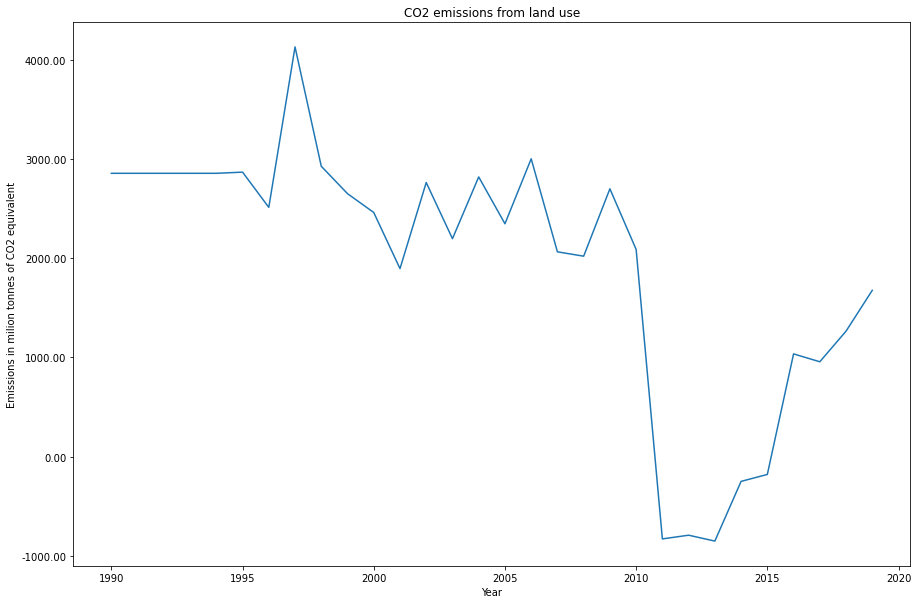

In [80]:
# cumulative emissions from land use
fig, ax = plt.subplots(figsize=(15,10))
plt.plot(all_land_emissions.Year.unique(),all_land_emissions.groupby("Year").sum()["Value"]/1000)
plt.xlabel("Year")
plt.ylabel("Emissions in milion tonnes of CO2 equivalent")
plt.title("CO2 emissions from land use")
ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))

plt.show()

In [81]:
all_land_emissions["Flag Description"][0]

'Aggregate, may include official, semi-official, estimated or calculated data'

In [82]:
all_land_emissions.groupby("Area").sum()["Value"].sort_values(ascending=False).head(50)

Area
Brazil                               50,837,480.59
Indonesia                            41,570,882.19
Democratic Republic of the Congo     26,965,813.92
Canada                                9,138,890.27
Myanmar                               7,789,198.06
Venezuela (Bolivarian Republic of)    6,378,516.88
Colombia                              4,882,617.75
Malaysia                              4,335,812.94
Peru                                  4,222,405.55
Bolivia (Plurinational State of)      4,105,260.90
Argentina                             3,793,039.34
United Republic of Tanzania           3,396,390.09
Mozambique                            3,391,090.42
Paraguay                              3,122,408.87
Nigeria                               2,827,945.11
Cameroon                              2,631,345.20
Botswana                              2,479,116.92
Côte d'Ivoire                         2,344,601.29
Papua New Guinea                      2,114,651.39
Angola                    

Biggest emissions from land come from developing countries, probably because of rapid deforestation and increased usage of land for farming animals. Let's visualise how these emissions changed over the years for some of these countries, as well as some of the biggest co2 emitors.

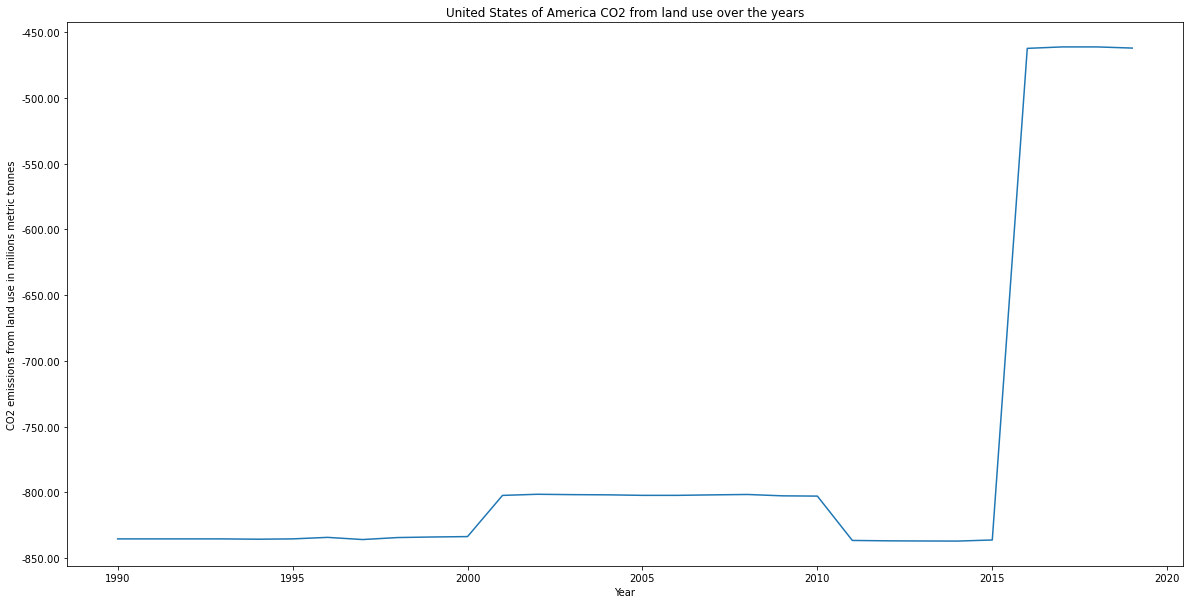

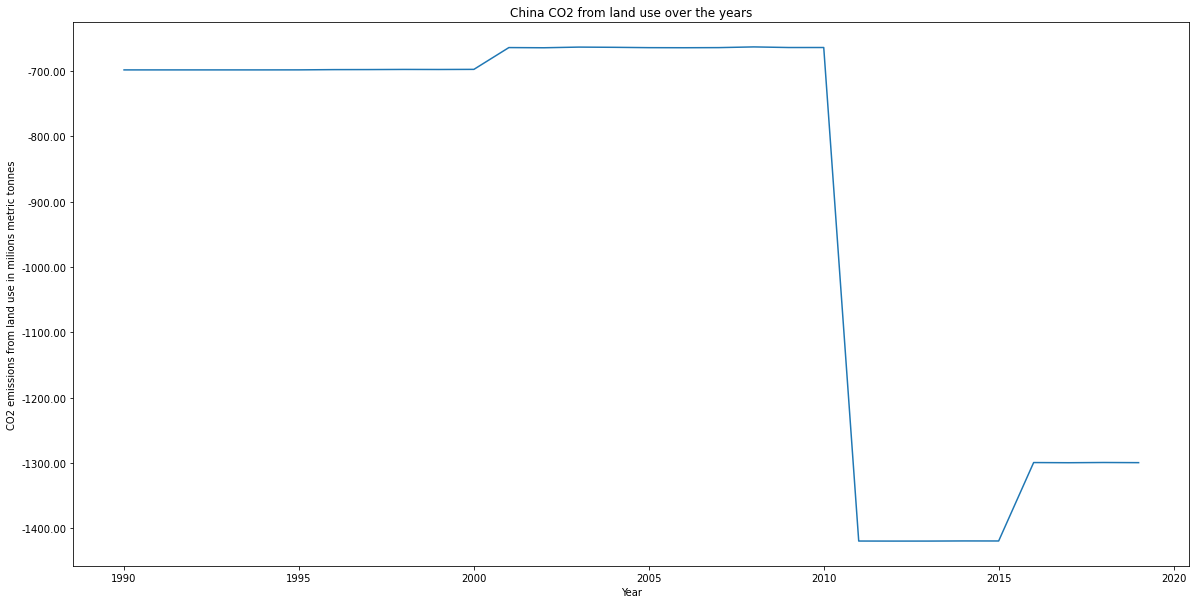

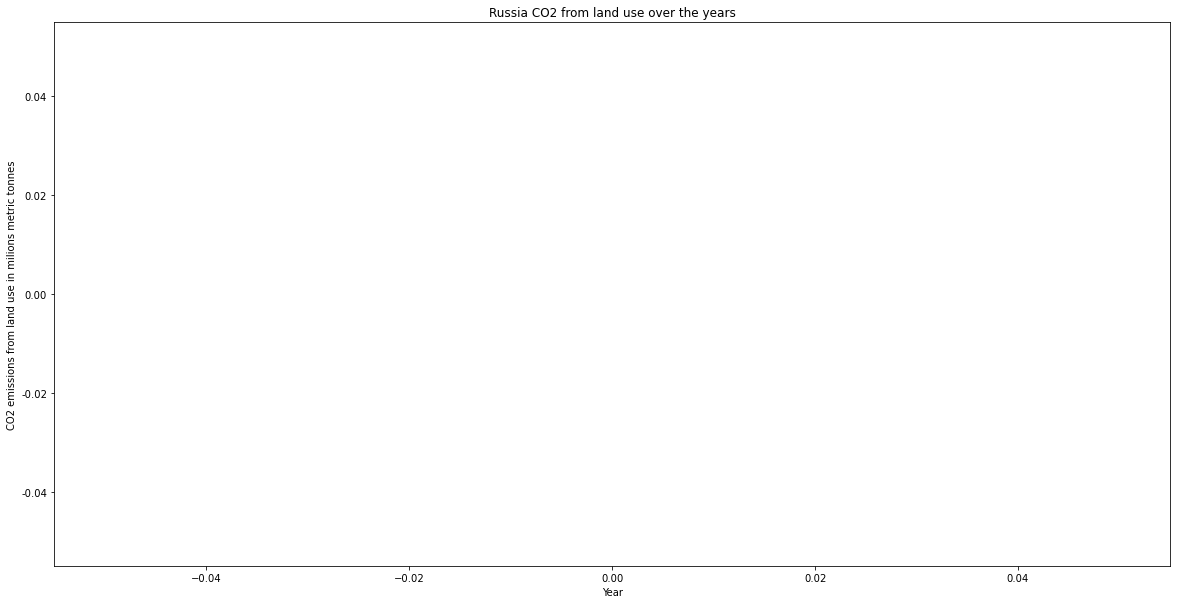

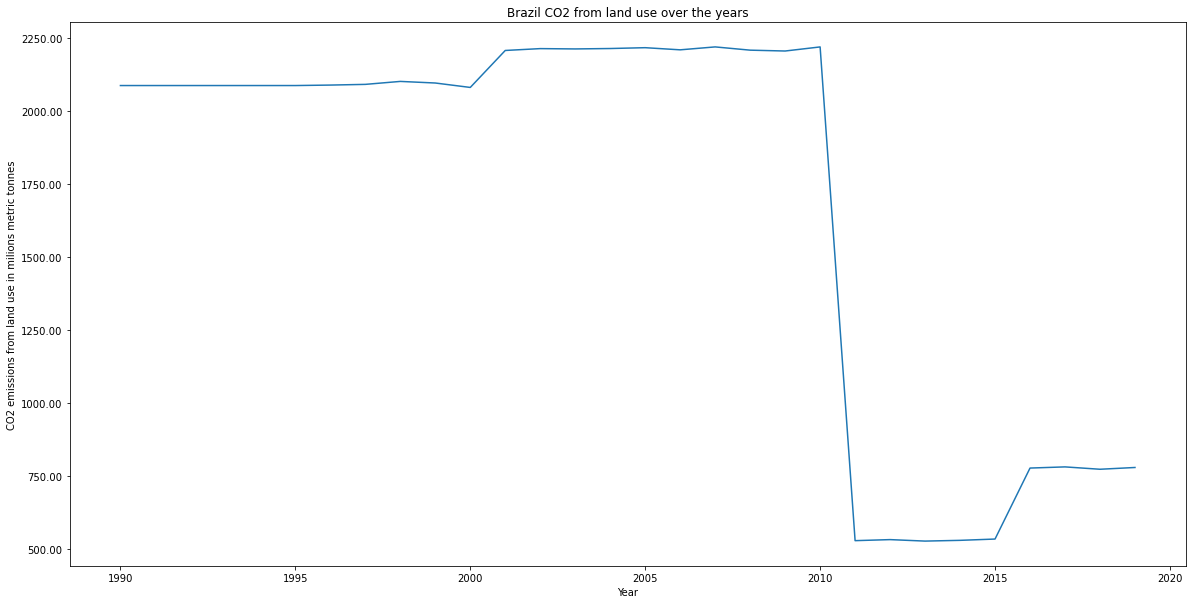

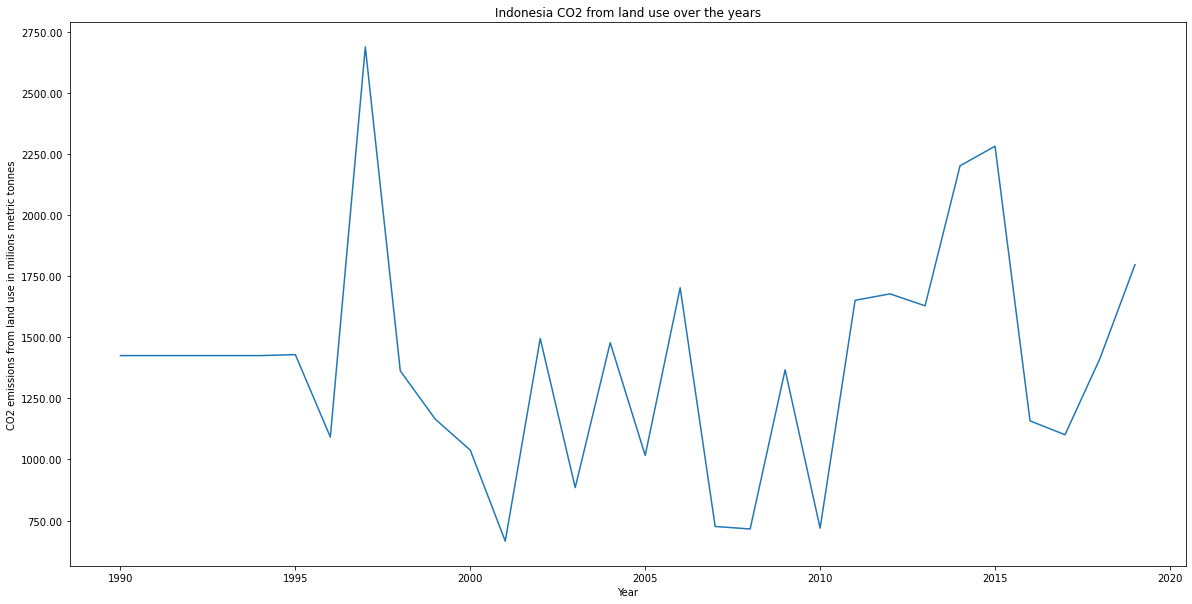

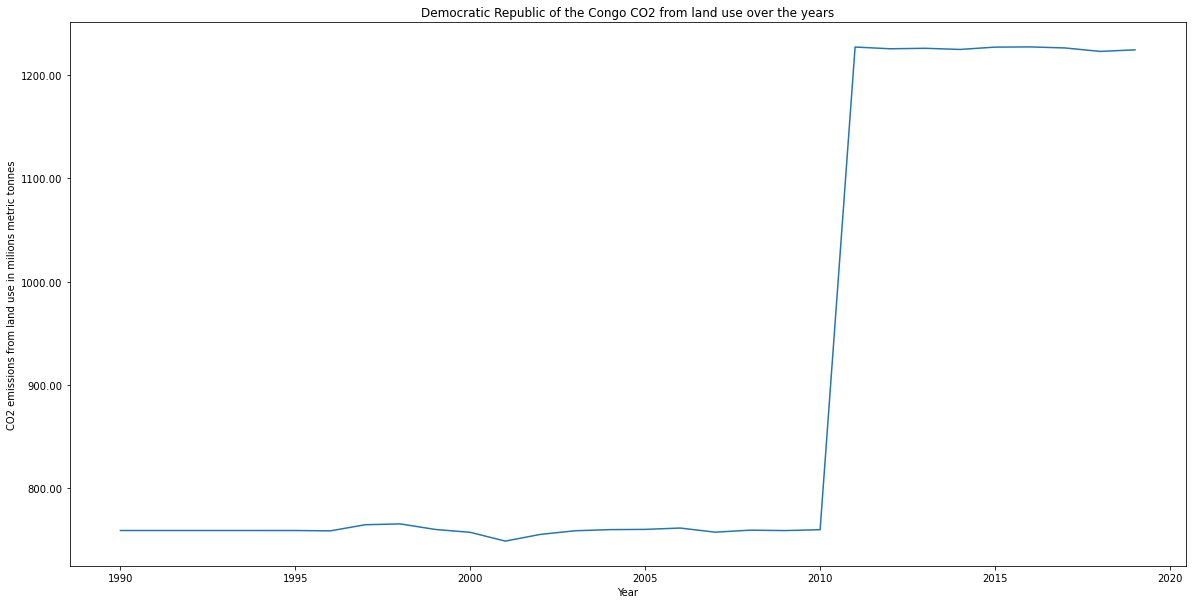

In [83]:
countries = ["United States of America","China","Russia","Brazil","Indonesia","Democratic Republic of the Congo"]

for country in countries:
    grouped = all_land_emissions[all_land_emissions.Area == country].groupby("Year")["Value"].sum()

    
    fig, ax = plt.subplots(figsize=(20,10))
    plt.plot(grouped.index,grouped/1000)
    plt.xlabel("Year")
    plt.ylabel("CO2 emissions from land use in milions metric tonnes")
    plt.title(f"{country} CO2 from land use over the years")
    ax.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    plt.show()

Land Use CO2 emissions are an important factor in human-made global warming. Even though these data are estimates, and do not allow to look for trends, etc, the should be considered while estimating whole man-made emissions

Let's take a look into data showing percentage of forest land by country

In [84]:
forest_cover

Country Name Country Code                Indicator Name  Indicator Code  \
0           Aruba          ABW  Forest area (% of land area)  AG.LND.FRST.ZS   
1     Afghanistan          AFG  Forest area (% of land area)  AG.LND.FRST.ZS   
2          Angola          AGO  Forest area (% of land area)  AG.LND.FRST.ZS   
3         Albania          ALB  Forest area (% of land area)  AG.LND.FRST.ZS   
4         Andorra          AND  Forest area (% of land area)  AG.LND.FRST.ZS   
..            ...          ...                           ...             ...   
259        Kosovo          XKX  Forest area (% of land area)  AG.LND.FRST.ZS   
260   Yemen, Rep.          YEM  Forest area (% of land area)  AG.LND.FRST.ZS   
261  South Africa          ZAF  Forest area (% of land area)  AG.LND.FRST.ZS   
262        Zambia          ZMB  Forest area (% of land area)  AG.LND.FRST.ZS   
263      Zimbabwe          ZWE  Forest area (% of land area)  AG.LND.FRST.ZS   

     1960  1961  1962  1963  1964  1965  ...  2012  2013  2014  2015  2016  \
0     NaN   NaN   NaN   NaN   NaN   NaN  ...  2.33  2.33  2.33  2.33  2.33   
1     NaN   NaN   NaN   NaN   NaN   NaN  ...  2.07  2.07  2.07  2.07  2.07   
2     NaN   NaN   NaN   NaN   NaN   NaN  ... 46.71 46.61 46.51 46.41 46.31   
3     NaN   NaN   NaN   NaN   NaN   NaN  ... 28.26 28.23 28.19 28.16 28.12   
4     NaN   NaN   NaN   NaN   NaN   NaN  ... 34.04 34.04 34.04 34.04 34.04   
..    ...   ...   ...   ...   ...   ...  ...   ...   ...   ...   ...   ...   
259   NaN   NaN   NaN   NaN   NaN   NaN  ...   NaN   NaN   NaN   NaN   NaN   
260   NaN   NaN   NaN   NaN   NaN   NaN  ...  1.04  1.04  1.04  1.04  1.04   
261   NaN   NaN   NaN   NaN   NaN   NaN  ...  7.62  7.62  7.62  7.62  7.62   
262   NaN   NaN   NaN   NaN   NaN   NaN  ... 66.10 65.87 65.65 65.42 65.20   
263   NaN   NaN   NaN   NaN   NaN   NaN  ... 38.77 37.97 37.16 36.35 35.54   

     2017  2018  2019  2020  Unnamed: 65  
0     NaN   NaN   NaN   NaN          NaN  
1     NaN   NaN   NaN   NaN          NaN  
2     NaN   NaN   NaN   NaN          NaN  
3     NaN   NaN   NaN   NaN          NaN  
4     NaN   NaN   NaN   NaN          NaN  
..    ...   ...   ...   ...          ...  
259   NaN   NaN   NaN   NaN          NaN  
260   NaN   NaN   NaN   NaN          NaN  
261   NaN   NaN   NaN   NaN          NaN  
262   NaN   NaN   NaN   NaN          NaN  
263   NaN   NaN   NaN   NaN          NaN  

[264 rows x 66 columns]

In [85]:
pd.set_option("display.max_rows",70)
forest_cover.isna().sum()

Country Name        0
Country Code        0
Indicator Name      0
Indicator Code      0
1960              264
1961              264
1962              264
1963              264
1964              264
1965              264
1966              264
1967              264
1968              264
1969              264
1970              264
1971              264
1972              264
1973              264
1974              264
1975              264
1976              264
1977              264
1978              264
1979              264
1980              264
1981              264
1982              264
1983              264
1984              264
1985              264
1986              264
1987              264
1988              264
1989              264
1990               16
1991               12
1992               12
1993               11
1994               11
1995               11
1996               11
1997               11
1998               11
1999               11
2000                9
2001      

Avaliable data is only from 1990 to 2016

In [86]:
forest_cover = forest_cover[["Country Name","1990","1991","1992","1993","1994","1995","1996","1997","1998","1999","2000",
             "2001","2002","2003","2004","2005","2006","2007","2008","2009","2010","2011","2012","2013",
             "2014","2015","2016"]]
forest_cover.dropna(inplace=True)

In [87]:
forest_cover

Country Name  1990  1991  1992  1993  1994  1995  1996  1997  1998  ...  \
0           Aruba  2.33  2.33  2.33  2.33  2.33  2.33  2.33  2.33  2.33  ...   
1     Afghanistan  2.07  2.07  2.07  2.07  2.07  2.07  2.07  2.07  2.07  ...   
2          Angola 48.91 48.81 48.71 48.61 48.51 48.41 48.31 48.21 48.11  ...   
3         Albania 28.79 28.72 28.65 28.57 28.50 28.43 28.36 28.29 28.22  ...   
4         Andorra 34.04 34.04 34.04 34.04 34.04 34.04 34.04 34.04 34.04  ...   
..            ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  ...   
258         Samoa 45.94 47.39 48.83 50.28 51.73 53.18 54.63 56.08 57.53  ...   
260   Yemen, Rep.  1.04  1.04  1.04  1.04  1.04  1.04  1.04  1.04  1.04  ...   
261  South Africa  7.62  7.62  7.62  7.62  7.62  7.62  7.62  7.62  7.62  ...   
262        Zambia 71.03 70.80 70.58 70.35 70.13 69.91 69.68 69.46 69.23  ...   
263      Zimbabwe 57.29 56.45 55.60 54.76 53.91 53.07 52.22 51.38 50.53  ...   

     2007  2008  2009  2010  2011  2012  2013  2014  2015  2016  
0    2.33  2.33  2.33  2.33  2.33  2.33  2.33  2.33  2.33  2.33  
1    2.07  2.07  2.07  2.07  2.07  2.07  2.07  2.07  2.07  2.07  
2   47.21 47.11 47.01 46.91 46.81 46.71 46.61 46.51 46.41 46.31  
3   28.47 28.42 28.38 28.33 28.30 28.26 28.23 28.19 28.16 28.12  
4   34.04 34.04 34.04 34.04 34.04 34.04 34.04 34.04 34.04 34.04  
..    ...   ...   ...   ...   ...   ...   ...   ...   ...   ...  
258 60.42 60.42 60.42 60.42 60.42 60.42 60.42 60.42 60.42 60.42  
260  1.04  1.04  1.04  1.04  1.04  1.04  1.04  1.04  1.04  1.04  
261  7.62  7.62  7.62  7.62  7.62  7.62  7.62  7.62  7.62  7.62  
262 67.22 66.99 66.77 66.54 66.32 66.10 65.87 65.65 65.42 65.20  
263 42.92 42.08 41.23 40.39 39.58 38.77 37.97 37.16 36.35 35.54  

[247 rows x 28 columns]

Change in forest cover around the world

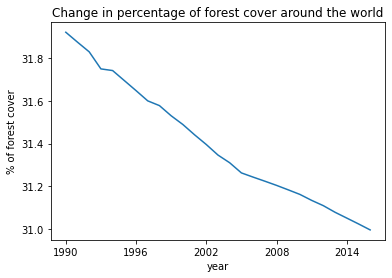

In [88]:
cover = [forest_cover[x].mean() for x in forest_cover.iloc[:,1:].columns]
yearz = forest_cover.iloc[:,1:].columns

plt.plot(yearz,cover)
plt.axes().xaxis.set_major_locator(plt.MaxNLocator(5))
plt.xlabel("year")
plt.ylabel("% of forest cover")
plt.title("Change in percentage of forest cover around the world")
plt.show()

Forest cover steadily declined over the years, by around 2% points

Countries with biggest forest cover decline

In [89]:
change_in_forest_cover = pd.Series((forest_cover["2016"].values - forest_cover["1990"].values),index=forest_cover["Country Name"].values).sort_values()
change_in_forest_cover = change_in_forest_cover.reset_index().rename({"index":"Country",0:"Pct of forest cover change"},axis=1)

In [90]:
change_in_forest_cover["Pct of forest cover change"].iloc[122] = 30

In [91]:
# reading vector map
shp_path = r"C:\Users\szklarnia\Desktop\datascience\projekty\globcio\vector\World_Countries.shp"

# creating GeoDataFrame with data and map info
map_df = gpd.read_file(shp_path).rename({"COUNTRY":"Country"},axis=1)

In [92]:
map_df[map_df.Country=="Iran"]

Country                                           geometry
106    Iran  MULTIPOLYGON (((60.80694 31.99666, 60.82347 31...

In [93]:
map_df.Country.replace({"Democratic Republic of the Congo":"Congo, Dem. Rep.","Russia":"Russian Federation",
                       "Iran":"Iran, Islamic Rep.","Egypt":"Egypt, Arab Rep.","Venezuela":"Venezuela, RB"},inplace=True)

In [94]:
to_plot = change_in_forest_cover.merge(map_df,on="Country")

In [95]:
to_plot = gpd.GeoDataFrame(to_plot)

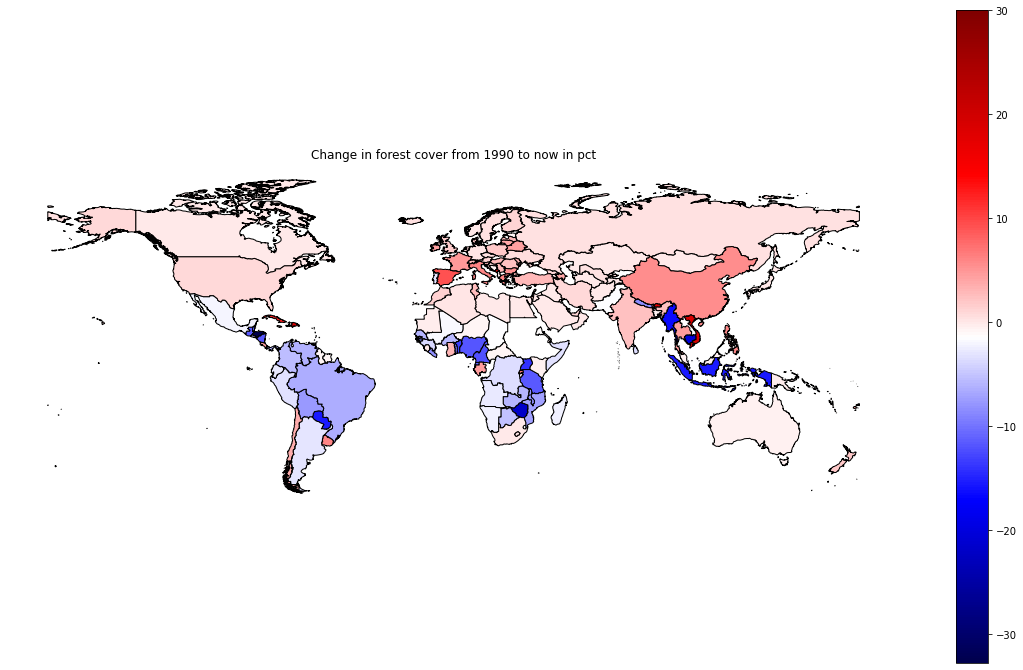

In [96]:
fig, ax = plt.subplots(1,figsize=(20,12))
to_plot.plot(column="Pct of forest cover change",ax=ax,cmap="seismic",legend=True,edgecolor="black")
plt.title("Change in forest cover from 1990 to now in pct")
ax.axis("off")
plt.show()

Currently biggest deforestation is happening in south-east Asia, South and Central Americas

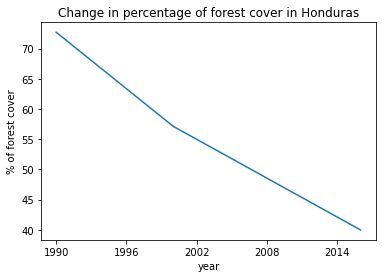

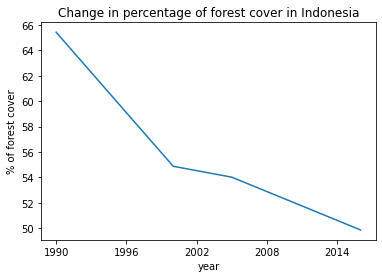

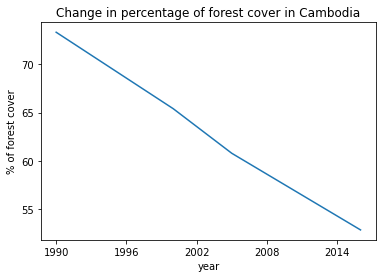

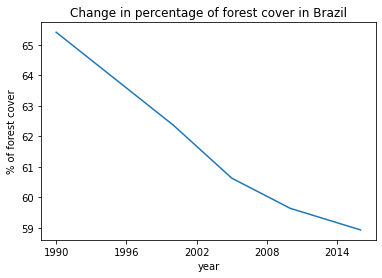

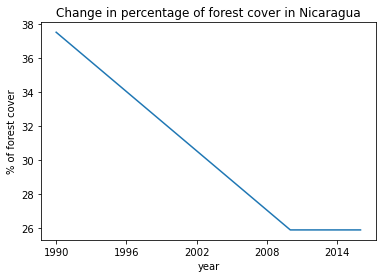

In [97]:
countries = ["Honduras","Indonesia","Cambodia","Brazil","Nicaragua"]

for country in countries:
    country_data = forest_cover[forest_cover["Country Name"]==country]
    cover = [country_data[x].values[0] for x in country_data.iloc[:,1:].columns]
    yearz = country_data.iloc[:,1:].columns

    plt.plot(yearz,cover)
    plt.axes().xaxis.set_major_locator(plt.MaxNLocator(5))
    plt.xlabel("year")
    plt.ylabel("% of forest cover")
    plt.title(f"Change in percentage of forest cover in {country}")
    plt.show()

The deforestation is happening in developing countries, where large, previously undamaged forest complexes are being cut down to allow farming, building roads etc. To reinforce this claim let's plot this data alongside GDP

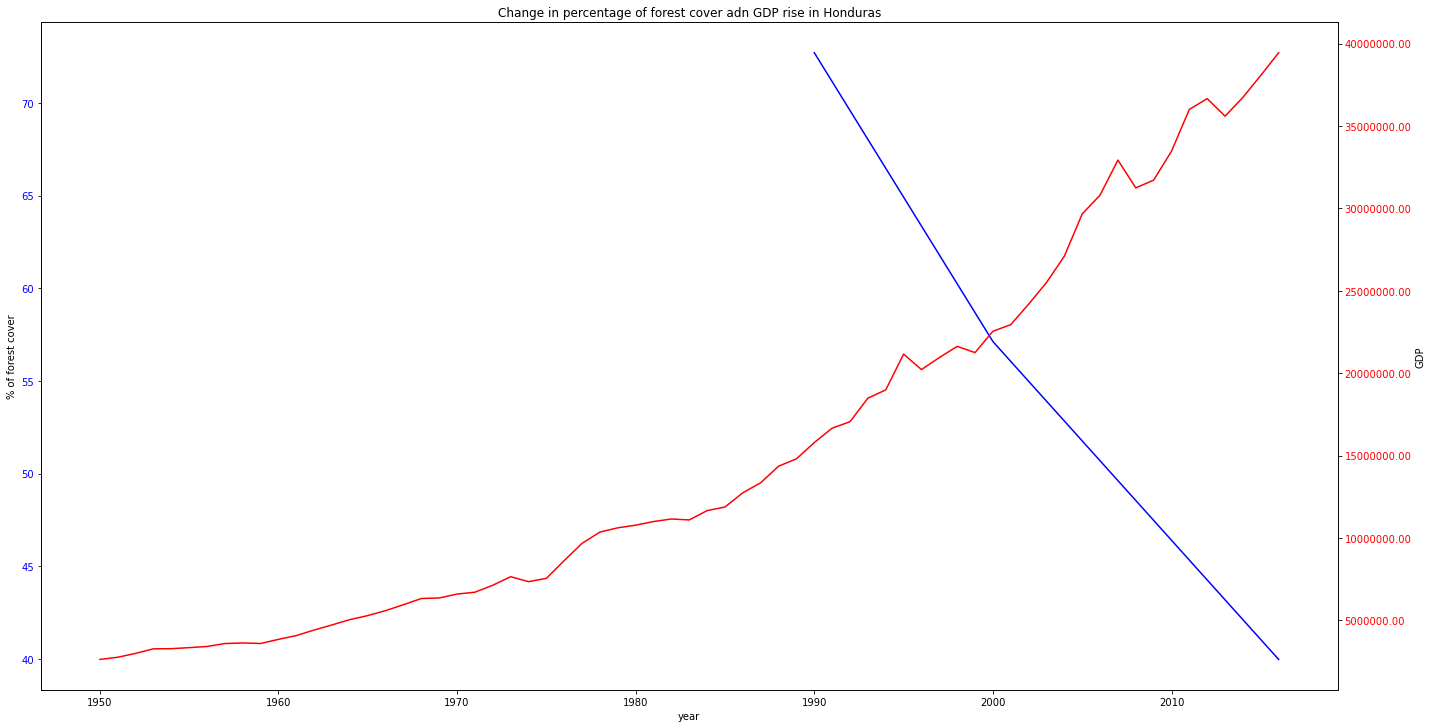

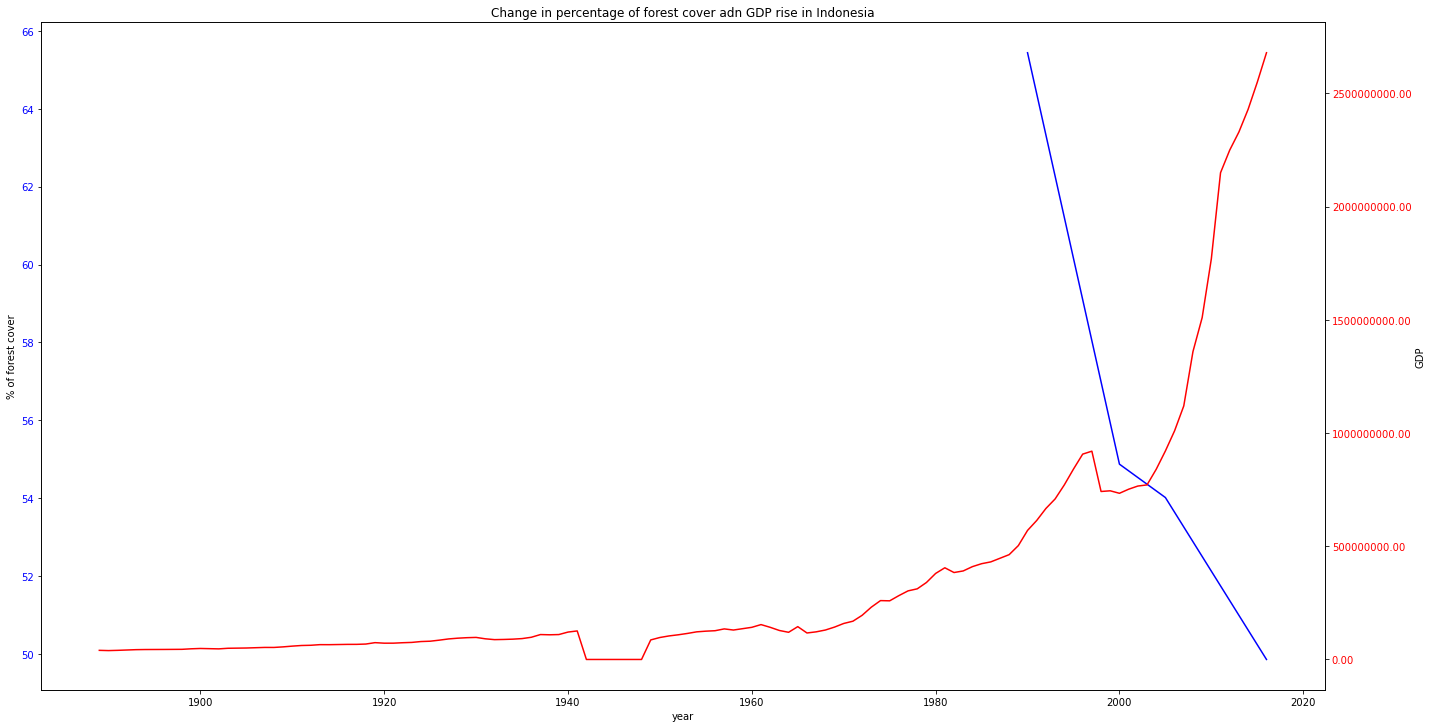

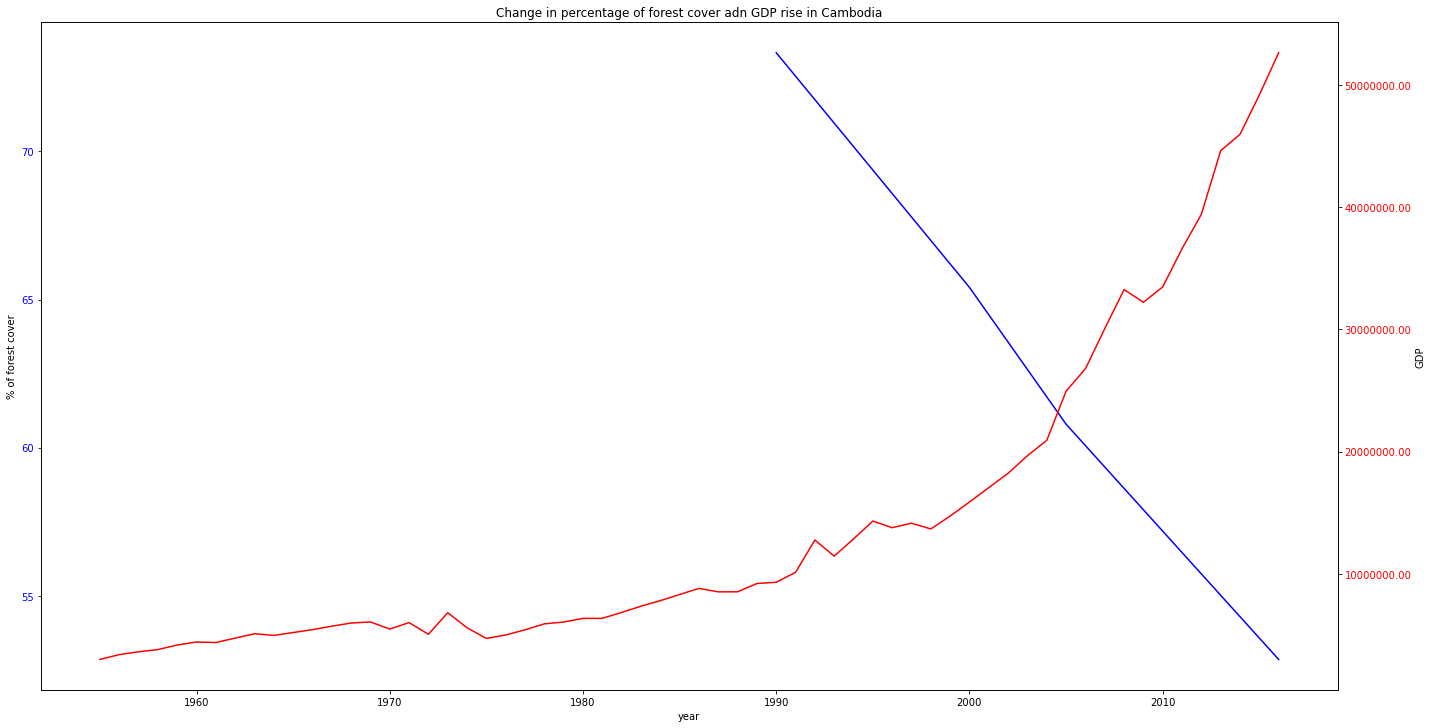

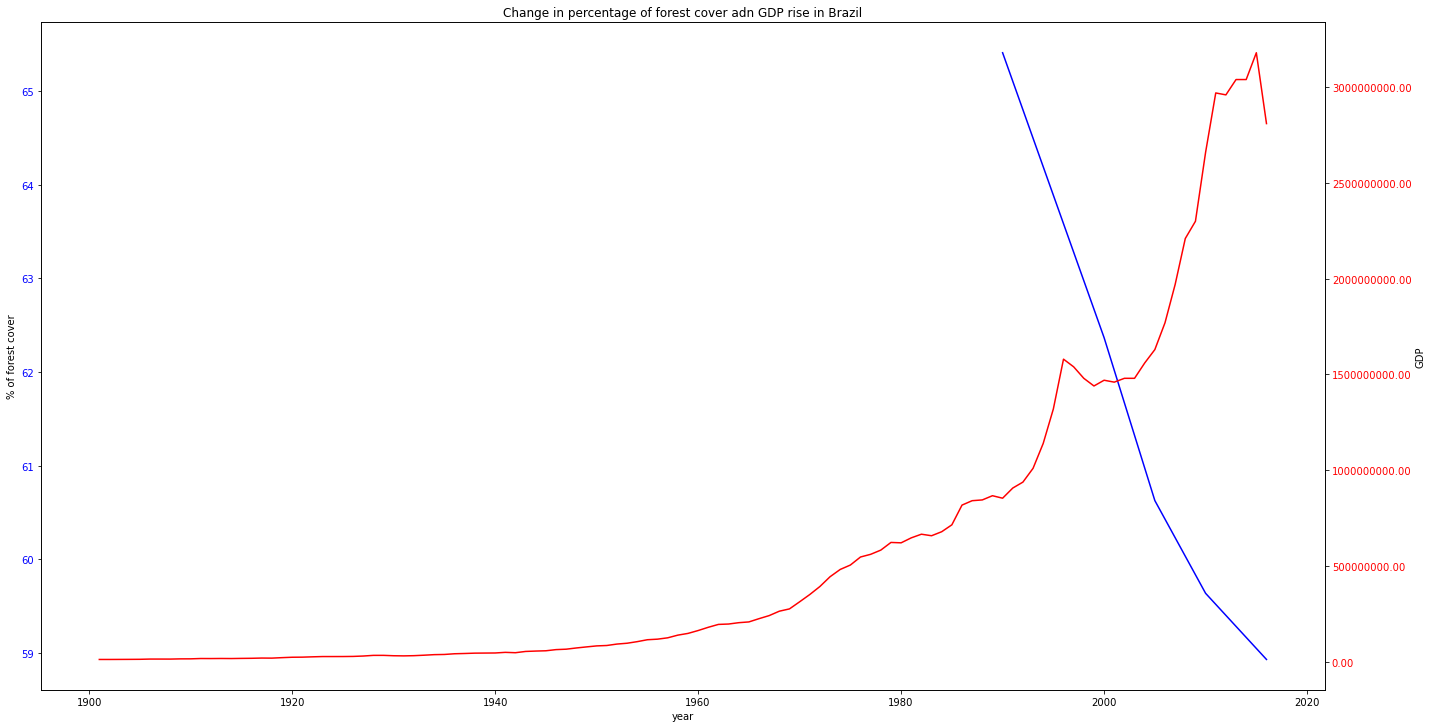

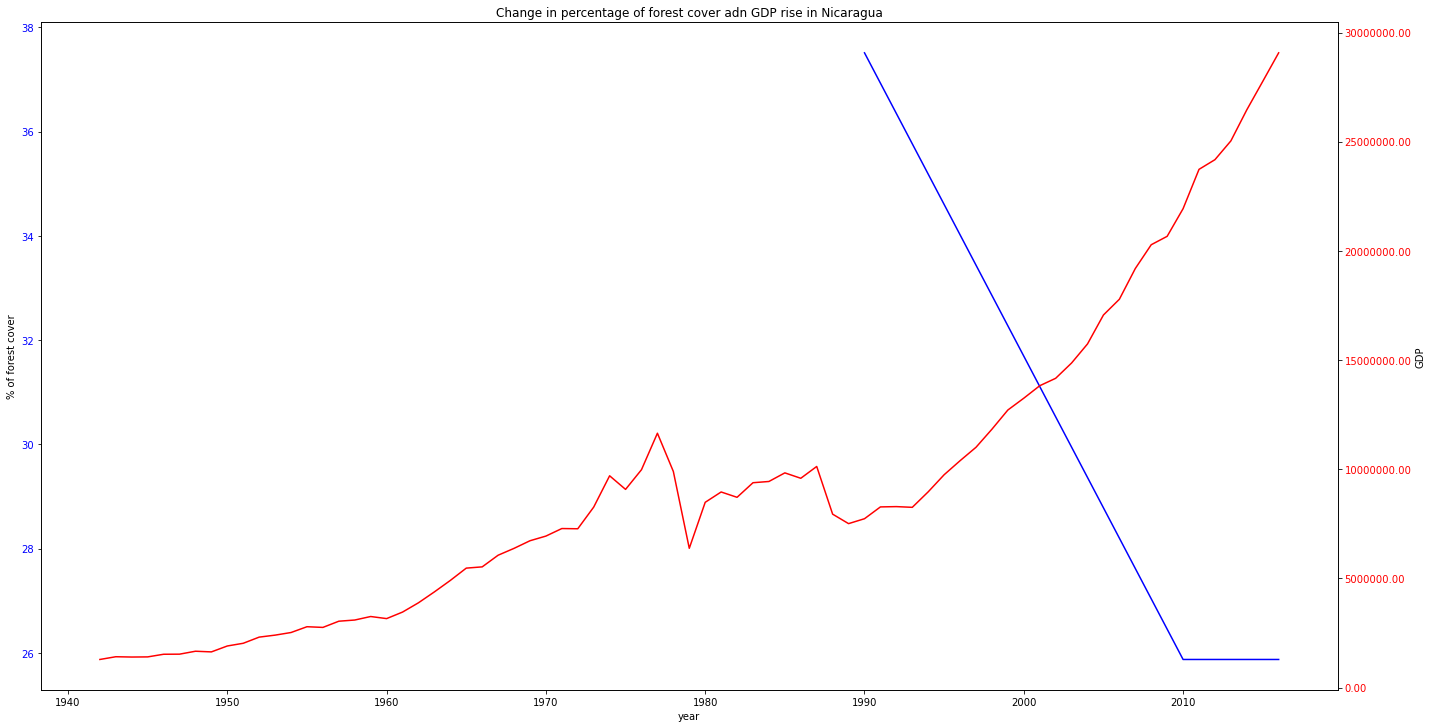

In [98]:
countries = ["Honduras","Indonesia","Cambodia","Brazil","Nicaragua"]

for country in countries:
    grouped = greenhouse[(greenhouse.country == country)&(greenhouse.year<2017)].groupby("year").sum()

    
    country_data = forest_cover[forest_cover["Country Name"]==country]
    cover = [country_data[x].values[0] for x in country_data.iloc[:,1:].columns]
    yearz = country_data.iloc[:,1:].columns.astype("int")
    
    fig, ax = plt.subplots(figsize=(20,10))
    ax.plot(yearz,cover,color="blue")
#     plt.axes().xaxis.set_major_locator(plt.MaxNLocator(5))
    ax.set_xlabel("year")
    ax.set_ylabel("% of forest cover")
    ax.tick_params(axis='y', labelcolor="blue")

    ax1 = ax.twinx()
    ax1.plot(grouped.index,grouped["gdp"].dropna()/1000,color="red")
    ax1.set_xlabel("Year")
    ax1.set_ylabel("GDP")
    ax1.yaxis.set_major_formatter(FormatStrFormatter('%.2f'))
    ax1.tick_params(axis='y', labelcolor="red")
    
    fig.tight_layout()
    plt.title(f"Change in percentage of forest cover adn GDP rise in {country}")
    plt.show()

GDP growth is negatively correlated with percentage of forrests in country - we can say that current development model of poorer countries drives deforestation. 

As deforestation is one of the main causes of CO2 emissions from land use, these analysis must be considered as worrying, as the process seems far from over.

# SUMMARY

### CO2 levels
All analyses show dynamic rise in CO2 and other greenhouse gasses emissions. These changes affect atmospheric concentration levels directly, as they are also quickly rising. Currently, greenhouse gasses concentration levels are higher than in any point in the last 800 thousand years, and probably for much, much longer. During Holocene and Pleistocene these levels fluctuated between 180 ppm in Glacial periods and 280-300 ppm in interglacials. 

## GDP and emissions
It is also clearly visible, that GDP rise globally is strongly correlated with emissions rise - it means that current development pattern is strongly tied to increased emissions, and humanity must finde other ways to develop, as this pattern is not sustainable

## Land Use and deforestation
Land Use also contributes to the rise of emissions, mainly from farming, deforestation etc. Globally percentage of forests shrinked by 2% in the last 25 years, but in some countries this change is much more dramatical. Developing countries with large areas of tropical rainforests, such as Brazil or Indonesia are rapidly reducing their forest cover, changing one of the biggest ecosystems